In [73]:
import numpy as np
import pandas as pd

# Financial news and sentiment analysis
from eodhd import APIClient
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import re

# Financial data
import yfinance as yf

# Data preparation and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from transformers import Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Graphs - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data balancing
from imblearn.over_sampling import SMOTE
import optuna
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

## 1. Gathering news headlines

We create a function that retrieves financial news articles for given stock symbols within a specified date range using the EODHD API and its Financial News endpoint.

This API uses this parameters:
- s: String. REQUIRED if parameter ‘t’ is not set. The ticker code to get news for.
- t: String. REQUIRED if parameter ‘s’ is not set. The tag to get news on a given topic.
- api_token: String. REQUIRED. Your api_token to access the API. You will get it after registration.
- from and to – the format is ‘YYYY-MM-DD’.
- limit: Number. OPTIONAL. The number of results should be returned with the query. Default value: 50, minimum value: 1, maximum value: 1000.
- offset: Number. OPTIONAL. The offset of the data. Default value: 0, minimum value: 0.

The output of the API is:
- date: The date and time of the article.
- title: The title of the article.
- content: The full body of the article.
- link: The link to the source.
- symbols: The array of ticker symbols is mentioned in the article.

Our function loops through each stock symbol in stock_symbols and:
- Calls the financial_news method of the APIClient instance to fetch news articles for the symbol within the given date range and with a specified limit on the number of articles.
- Converts the response to a DataFrame news_df.
- Adds a new column symbol to the DataFrame to indicate which stock the news articles are related to.
- Concatenates news_df to all_news_df.
- and returns a combined DataFrame, all_news_df, containing news articles for all specified stock symbols.

In [74]:
def get_news_headlines(api_key, stock_symbols, from_date, to_date, limit=200):
    # Instance of APIClient
    client = APIClient(api_key)
    # DataFrame to store all the news articles
    all_news_df = pd.DataFrame()
    
    for symbol in stock_symbols:
        resp = client.financial_news(s=symbol, from_date=from_date, to_date=to_date, limit=limit)
        news_df = pd.DataFrame(resp)
        news_df['symbol'] = symbol
        all_news_df = pd.concat([all_news_df, news_df], ignore_index=True)
    
    return all_news_df

In [75]:
api_key = '665374cb4f8030.36752695'
stock_symbols = ["AAPL.US", "MSFT.US", "GOOGL.US", "NVDA.US", "DIS.US", "V.US", "TSLA.US", "BRK-A.US"]
from_date = '2023-01-01'
to_date = '2024-05-31'

all_news_df = get_news_headlines(api_key, stock_symbols, from_date, to_date)

## 2. Sentiment analysis

We create a function that is used to preprocess and clean headlines text data before performing sentiment analysis. This funtion:
1.	Removes any punctuation from the text while keeping alphanumeric characters, whitespace, and percentage symbols using a regular expression. We decided to retain the numbers and the percentage symbol because we believe that news stories that include them can provide important quantitative information about stock prices, financial metrics, and market movements.
2.	Lowercase the headline to ensure uniformity and eliminate case sensitivity.
3.	Removes any extra spaces, including leading and trailing spaces, and reduces multiple spaces between words to a single space to maintain consistency in the text format.

In [76]:
def clean_text(text):
    # Remove punctuation, keeping numbers and percentage symbols
    text = re.sub(r'[^\w\s%]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

This function prepares the news headlines for machine learning by cleaning the text, calculating sentiment scores using both TextBlob and VADER, and converting the cleaned text into TF-IDF features. The sentiment scores are then added as additional features to the TF-IDF matrix, enhancing the feature set with both textual and sentiment information.
The function returns the updated news_df DataFrame with additional sentiment columns, the augmented feature matrix X, and the fitted TF-IDF vectorizer.

We decided to use two sentiment analyzers to provide a more comprehensive sentiment analysis by leveraging their respective strengths:
- TextBlob is based on a lexicon approach, where it uses predefined dictionaries of word polarities.
- VADER is also a lexicon and rule-based sentiment analysis tool, but it is particularly attuned to sentiments expressed in social media and financial contexts. It accounts for sentiment intensity and can handle punctuations, capitalization, degree modifiers, and more effectively.
By combining the sentiment scores from both tools, we aim to capture a wider range of sentiment nuances and improve the robustness of our sentiment analysis.


In [77]:
def preprocess_and_analyze_news(news_df):
    # Initialize the VADER sentiment analyzer
    vader_analyzer = SentimentIntensityAnalyzer()

    # Clean the news headlines
    news_df['cleaned_title'] = news_df['title'].apply(clean_text)
    
    # Sentiment using TextBlob
    news_df['sentiment_textblob'] = news_df['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Sentiment using VADER
    news_df['sentiment_vader'] = news_df['cleaned_title'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
    
    # Convert news headlines to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(news_df['cleaned_title'])
    
    # Add sentiment scores as additional features
    X = scipy.sparse.hstack((X, news_df[['sentiment_textblob', 'sentiment_vader']].values))
    
    return news_df, X, vectorizer

Stock markets typically operate only on weekdays, and the news published on weekends may not have an immediate impact on stock prices. So we create a function to filter news articles that were published on weekends, retaining only those published on weekdays. By focusing on weekday news, the analysis can be more relevant and aligned with market activities (also because there is no financial information for weekends).

In [78]:
def filter_weekend_news(news_df):
    # Add a weekday column to the DataFrame, where Monday is 0 and Sunday is 6
    news_df.loc[:, 'weekday'] = pd.to_datetime(news_df['date']).dt.weekday
    # Keep only the rows where the weekday is less than 5, monday to friday
    filtered_news_df = news_df[news_df['weekday'] < 5].copy()
    # Drop the weekday column because is not needed for ML process
    filtered_news_df.drop(columns=['weekday'], inplace=True)
    return filtered_news_df

In [79]:
filtered_news_df = filter_weekend_news(all_news_df)
news_df, X, vectorizer = preprocess_and_analyze_news(filtered_news_df)

In [80]:
news_df.head()

,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader
0,2024-05-31T16:15:00+00:00,Implied Volatility Surging for Apple (AAPL) St...,"Investors in Apple, Inc AAPL need to pay close...",https://finance.yahoo.com/news/implied-volatil...,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.US,...",[],"{'polarity': 0.988, 'neg': 0.018, 'neu': 0.876...",AAPL.US,implied volatility surging for apple aapl stoc...,0.00000000,0.00000000
1,2024-05-31T16:14:18+00:00,Apple Supplier Luxshare Accused of Illegal Ope...,Apple Supplier Luxshare Accused of Illegal Ope...,https://finance.yahoo.com/news/apple-supplier-...,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.US,...",[],"{'polarity': 0.802, 'neg': 0.078, 'neu': 0.825...",AAPL.US,apple supplier luxshare accused of illegal ope...,-0.50000000,-0.45880000
2,2024-05-31T14:52:37+00:00,NVIDIA is a shoo-in for the Dow post stock split,"With its latest earnings report, AI darling NV...",https://finance.yahoo.com/news/nvidia-shoo-dow...,"[1INTC.MI, 1NVDA.MI, AAPL.US, AMGN.US, CRM.US,...",[],"{'polarity': 0.98, 'neg': 0.011, 'neu': 0.931,...",AAPL.US,nvidia is a shooin for the dow post stock split,0.00000000,0.00000000
3,2024-05-31T14:35:17+00:00,Nvidia set to overtake Apple as world's second...,By Medha Singh\n\n(Reuters) - Nvidia could soo...,https://finance.yahoo.com/news/nvidia-set-over...,"[0R2V.IL, 1NVDA.MI, AAPL.BA, AAPL.MX, AAPL.NEO...",[],"{'polarity': 0.989, 'neg': 0.025, 'neu': 0.873...",AAPL.US,nvidia set to overtake apple as worlds secondm...,0.00000000,0.47670000
4,2024-05-31T14:22:58+00:00,OpenAI's Apple Deal Sparks Concerns In Microso...,OpenAI's Apple Deal Sparks Concerns In Microso...,https://finance.yahoo.com/news/openais-apple-d...,"[0QYP.IL, 0R2V.IL, 0RIH.IL, 1GOOG.MI, 1GOOGL.M...",[],"{'polarity': 0.98, 'neg': 0.026, 'neu': 0.878,...",AAPL.US,openais apple deal sparks concerns in microsof...,0.00000000,0.27320000


To better understand the distribution and impact of news sentiment on stock prices, we created several visualizations using the sentiment scores derived from TextBlob and VADER. These visualizations help us to see how sentiment varies and how it might relate to stock performance.

This plot shows the distribution of sentiment scores for all news headlines. We visualize the scores calculated by both TextBlob and VADER, providing a comparative view of how each tool evaluates sentiment across the dataset.

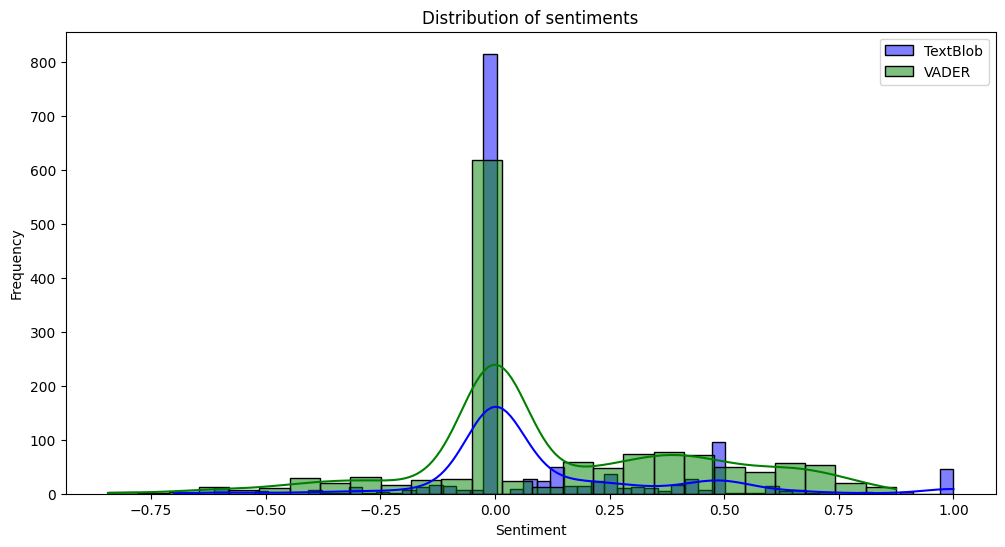

In [81]:
plt.figure(figsize=(12, 6))
sns.histplot(news_df['sentiment_textblob'], kde=True, color='blue', label='TextBlob')
sns.histplot(news_df['sentiment_vader'], kde=True, color='green', label='VADER')
plt.title('Distribution of sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This bar chart illustrates the average sentiment score for each stock, using both TextBlob and VADER scores. It helps to identify which stocks generally have more positive or negative sentiment in the news, providing a clearer picture of market perception.

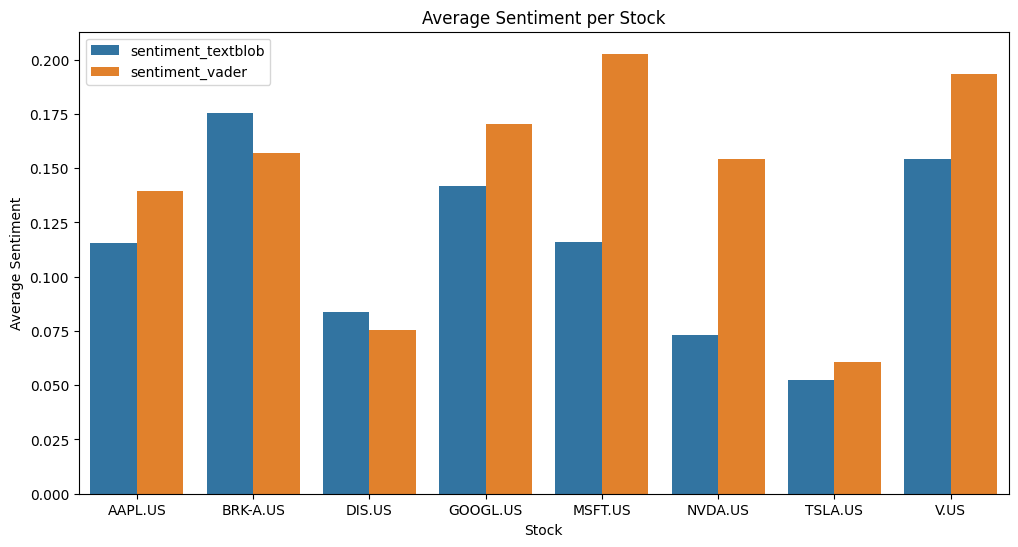

In [82]:
avg_sentiment = news_df.groupby('symbol')[['sentiment_textblob', 'sentiment_vader']].mean().reset_index()
avg_sentiment = pd.melt(avg_sentiment, id_vars=['symbol'], value_vars=['sentiment_textblob', 'sentiment_vader'], var_name='Sentiment Type', value_name='Sentiment Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment, x='symbol', y='Sentiment Score', hue='Sentiment Type')
plt.title('Average Sentiment per Stock')
plt.xlabel('Stock')
plt.ylabel('Average Sentiment')
plt.legend()
plt.show()

This series of subplots shows the sentiment scores over time for each stock. By plotting the daily average sentiment, we can observe trends and fluctuations in sentiment, offering insights into how news sentiment might be influencing stock prices over different periods.

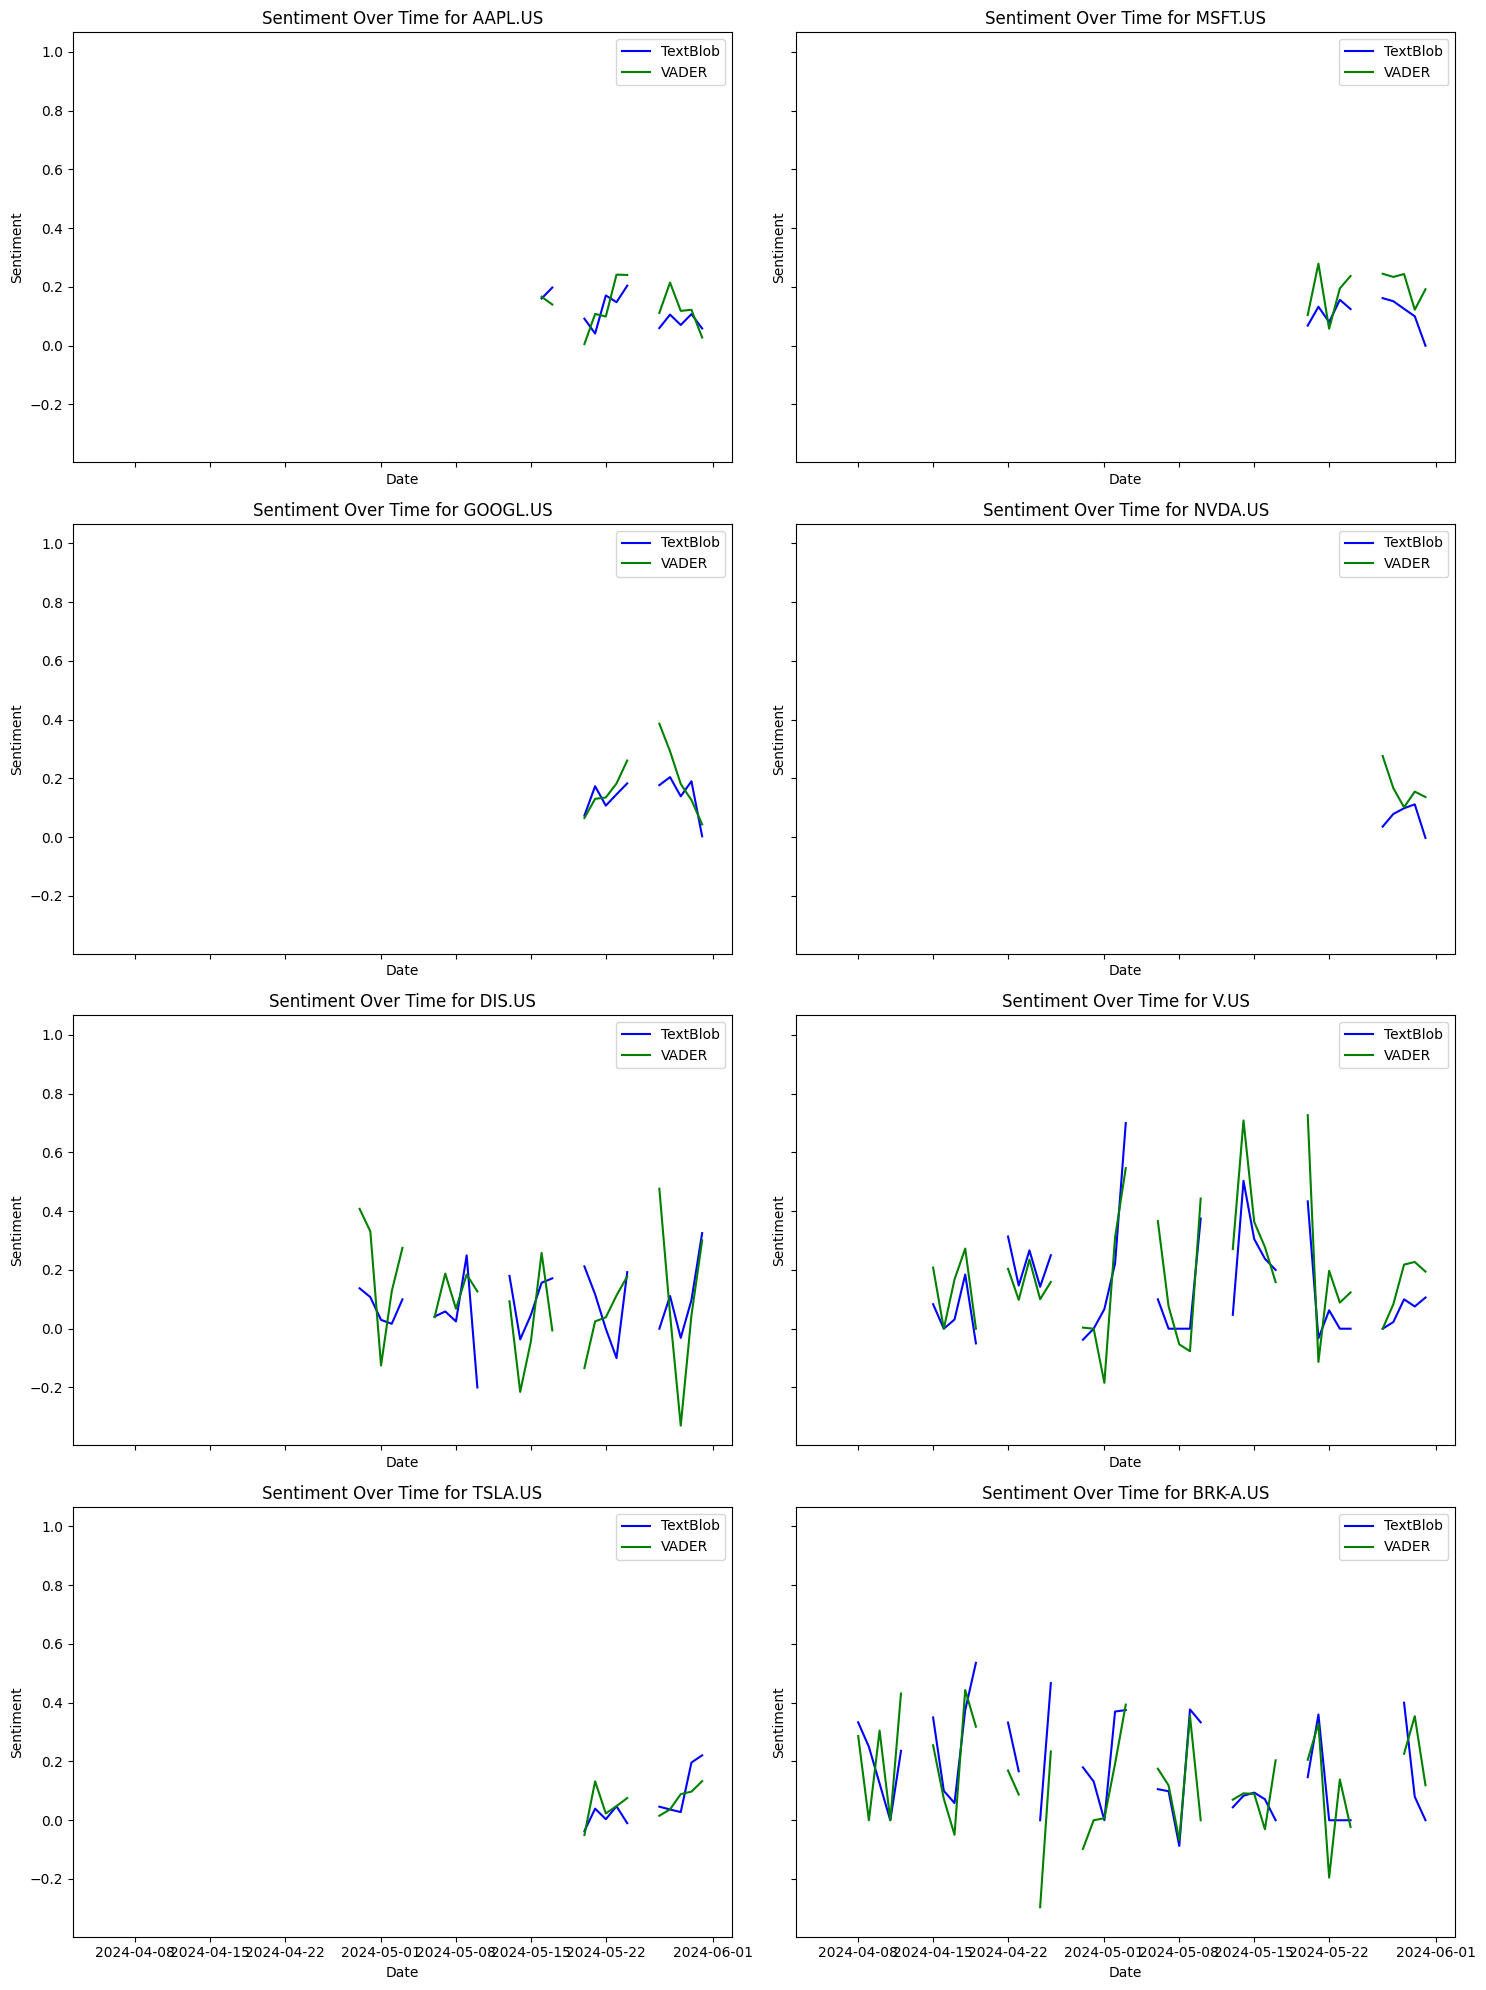

In [83]:
news_df['date'] = pd.to_datetime(news_df['date'])

num_stocks = len(stock_symbols)
cols = 2
rows = (num_stocks // cols) + (num_stocks % cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, symbol in enumerate(stock_symbols):
    stock_news = news_df[news_df['symbol'] == symbol].set_index('date')
    stock_news = stock_news[['sentiment_textblob', 'sentiment_vader']].resample('D').mean().reset_index()
    
    axes[i].plot(stock_news['date'], stock_news['sentiment_textblob'], label='TextBlob', color='blue')
    axes[i].plot(stock_news['date'], stock_news['sentiment_vader'], label='VADER', color='green')
    axes[i].set_title(f'Sentiment Over Time for {symbol}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sentiment')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 3. Gathering financial information

This function collects historical stock prices from Yahoo Finance for a given list of stock symbols within a specified date range. The data is fetched using the yfinance library.
    
Parameters:
- stock_symbols: List of stock symbols to fetch data for.
- from_date: Start date for the historical data.
- to_date: End date for the historical data.

Returns:
- all_prices_df: A DataFrame containing the historical stock prices for all specified symbols.

In [84]:
def get_stock_prices(stock_symbols, from_date, to_date):
    all_prices_df = pd.DataFrame()
    
    for symbol in stock_symbols:
        # Remove the ".US" suffix from the symbol for yfinance compatibility
        stock_symbol = symbol.split('.')[0]
        # Fetch the historical stock data from Yahoo Finance
        stock_data = yf.download(stock_symbol, start=from_date, end=to_date)
        # Re-add the suffix ".US" to the symbol
        stock_data['symbol'] = symbol
        # Reset the index to include the date as a column
        stock_data.reset_index(inplace=True)
        # Concatenate the new data with the existing DataFrame
        all_prices_df = pd.concat([all_prices_df, stock_data], ignore_index=True)

    return all_prices_df

In [85]:
all_prices_df = get_stock_prices(stock_symbols, from_date, to_date)
all_prices_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,symbol
0,2023-01-03,130.27999878,130.89999390,124.16999817,125.06999969,124.04804993,112117500,AAPL.US
1,2023-01-04,126.88999939,128.66000366,125.08000183,126.36000061,125.32750702,89113600,AAPL.US
2,2023-01-05,127.12999725,127.76999664,124.76000214,125.01999664,123.99845886,80962700,AAPL.US
3,2023-01-06,126.01000214,130.28999329,124.88999939,129.61999512,128.56086731,87754700,AAPL.US
4,2023-01-09,130.47000122,133.41000366,129.88999939,130.14999390,129.08653259,70790800,AAPL.US


This function calculates the daily percentage change in closing prices for each stock symbol.

Parameters:
- prices_df: DataFrame containing historical stock prices with columns 'symbol', 'Date', and 'Close'.

Returns:
- prices_df: DataFrame with an additional column 'price_change' representing the daily percentage change in closing prices for each stock symbol.

In [86]:
def calculate_price_changes(prices_df):
    # Date column in datetime format
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])
    # Sort the DataFrame by symbol and Date to ensure correct calculation of changes
    prices_df = prices_df.sort_values(by=['symbol', 'Date'])
    # Calculate the daily percentage change in closing prices for each stock symbol
    prices_df['price_change'] = prices_df.groupby('symbol')['Close'].pct_change()
    # prices_df['price_change'] = prices_df.groupby('symbol')['Close'].diff()
    
    return prices_df

In [87]:
# Calcolo delle variazioni di prezzo
all_prices_df = calculate_price_changes(all_prices_df)
all_prices_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,price_change
0,2023-01-03,130.27999878,130.89999390,124.16999817,125.06999969,124.04804993,112117500,AAPL.US,NaN
1,2023-01-04,126.88999939,128.66000366,125.08000183,126.36000061,125.32750702,89113600,AAPL.US,0.01031423
2,2023-01-05,127.12999725,127.76999664,124.76000214,125.01999664,123.99845886,80962700,AAPL.US,-0.01060465
3,2023-01-06,126.01000214,130.28999329,124.88999939,129.61999512,128.56086731,87754700,AAPL.US,0.03679410
4,2023-01-09,130.47000122,133.41000366,129.88999939,130.14999390,129.08653259,70790800,AAPL.US,0.00408887


## 4. Merge News Headlines + Financial Information

This function merges financial news data with historical stock price data based on matching dates and stock symbols.

In [88]:
def merge_news_and_prices(news_df, prices_df):
    # Convert the date column to datetime format and extract the date part
    news_df['date'] = pd.to_datetime(news_df['date']).dt.date
    prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
    
    # Identify dates that are present in news_df but missing in prices_df (days where the market is closed for holidays)
    missing_dates = set(news_df['date'].unique()) - set(prices_df['Date'].unique())
    # print("Date mancanti nei dati finanziari:", missing_dates)
    
    # Filter out news articles that correspond to missing dates
    news_df = news_df[~news_df['date'].isin(missing_dates)]
    
    # Merge the news data with the stock price data based on matching symbol and date
    merged_df = pd.merge(news_df, prices_df, left_on=['symbol', 'date'], right_on=['symbol', 'Date'])

    return merged_df

In [89]:
merged_df = merge_news_and_prices(news_df, all_prices_df)
merged_df.head()

,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader,Date,Open,High,Low,Close,Adj Close,Volume,price_change
0,2024-05-30,Apple Plans AI-Based Siri Overhaul to Control ...,(Bloomberg) -- Apple Inc. is planning to overh...,https://finance.yahoo.com/news/apple-plans-ai-...,"[0R2V.IL, 0RIH.IL, 1GOOG.MI, 1GOOGL.MI, AAPL.B...",[],"{'polarity': 0.997, 'neg': 0.014, 'neu': 0.898...",AAPL.US,apple plans aibased siri overhaul to control i...,0.00000000,0.00000000,2024-05-30,190.75999451,192.17999268,190.63000488,191.28999329,191.28999329,49947900,0.00525514
1,2024-05-30,1 Spectacular Growth Stock That Could Join Nvi...,Fool.com contributor Parkev Tatevosian highlig...,https://finance.yahoo.com/news/1-spectacular-g...,"[AAPL.US, GOOG.US, GOOGL.US, META.US, MSFT.US,...",[],"{'polarity': -0.705, 'neg': 0.078, 'neu': 0.85...",AAPL.US,1 spectacular growth stock that could join nvi...,0.60000000,0.58590000,2024-05-30,190.75999451,192.17999268,190.63000488,191.28999329,191.28999329,49947900,0.00525514
2,2024-05-30,"Apple iPhone Sales Weak In China, U.S.: Report",Apple iPhone unit sales are soft and underperf...,https://finance.yahoo.com/m/ad128b51-da00-3a2c...,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.US,...",[],"{'polarity': 0, 'neg': 0, 'neu': 1, 'pos': 0}",AAPL.US,apple iphone sales weak in china us report,-0.37500000,-0.44040000,2024-05-30,190.75999451,192.17999268,190.63000488,191.28999329,191.28999329,49947900,0.00525514
3,2024-05-30,Warner Bros. Discovery CEO says company has 'f...,Warner Bros. Discovery (WBD) CEO David Zaslav ...,https://finance.yahoo.com/news/warner-bros-dis...,"[0R1O.IL, 0R2V.IL, 0RIH.IL, 0RIH.LSE, 1AMZN.MI...",[],"{'polarity': 0.971, 'neg': 0.032, 'neu': 0.892...",AAPL.US,warner bros discovery ceo says company has ful...,0.35000000,-0.15310000,2024-05-30,190.75999451,192.17999268,190.63000488,191.28999329,191.28999329,49947900,0.00525514
4,2024-05-30,Nvidia Could Surpass Microsoft in Market Value...,Nvidia Could Surpass Microsoft in Market Value...,https://finance.yahoo.com/news/nvidia-could-su...,"[0QYP.IL, 1MSFT.MI, 1NVDA.MI, AAPL.US, AMZN.US...",[],"{'polarity': 0.986, 'neg': 0.025, 'neu': 0.858...",AAPL.US,nvidia could surpass microsoft in market value...,0.00000000,0.34000000,2024-05-30,190.75999451,192.17999268,190.63000488,191.28999329,191.28999329,49947900,0.00525514


In [90]:
# Analisi descrittiva
def analyze_dataset(df):
    print("Dataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 10))
    
    # Seleziona solo le colonne numeriche
    numeric_df = df.select_dtypes(include=[np.number])
    
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matrice di Correlazione')
    plt.show()

In [91]:
# Analizza il dataset
analyze_dataset(merged_df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1252 non-null   object 
 1   title               1252 non-null   object 
 2   content             1252 non-null   object 
 3   link                1252 non-null   object 
 4   symbols             1252 non-null   object 
 5   tags                1252 non-null   object 
 6   sentiment           1252 non-null   object 
 7   symbol              1252 non-null   object 
 8   cleaned_title       1252 non-null   object 
 9   sentiment_textblob  1252 non-null   float64
 10  sentiment_vader     1252 non-null   float64
 11  Date                1252 non-null   object 
 12  Open                1252 non-null   float64
 13  High                1252 non-null   float64
 14  Low                 1252 non-null   float64
 15  Close               1252 non-null   float

In [92]:
# plt.figure(figsize=(8, 6))
# sns.countplot(x='label', data=merged_df)
# plt.title('Distribuzione delle Etichette')
# plt.xlabel('Etichetta')
# plt.ylabel('Conteggio')
# plt.show()

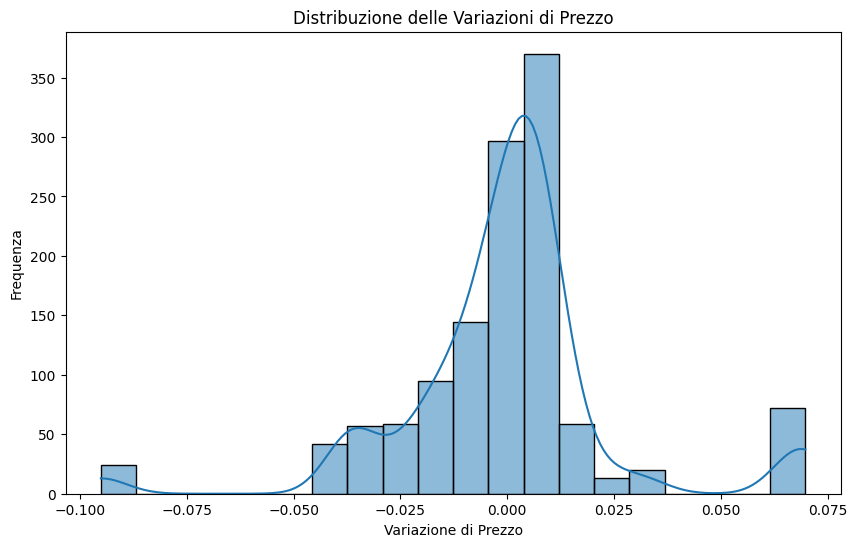

In [93]:
# Visualizza la distribuzione delle variazioni di prezzo
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['price_change'], bins=20, kde=True)
plt.title('Distribuzione delle Variazioni di Prezzo')
plt.xlabel('Variazione di Prezzo')
plt.ylabel('Frequenza')
plt.show()

In [94]:
# # Grafico della relazione tra sentiment e variazioni di prezzo

# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='sentiment_textblob', y='price_change', data=merged_df, hue='label')
# plt.title('Relazione tra Sentiment e Variazioni di Prezzo')
# plt.xlabel('Sentiment (TextBlob)')
# plt.ylabel('Variazione di Prezzo')
# plt.show()

# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='sentiment_vader', y='price_change', data=merged_df, hue='label')
# plt.title('Relazione tra Sentiment e Variazioni di Prezzo')
# plt.xlabel('Sentiment (VADER)')
# plt.ylabel('Variazione di Prezzo')
# plt.show()
# # 

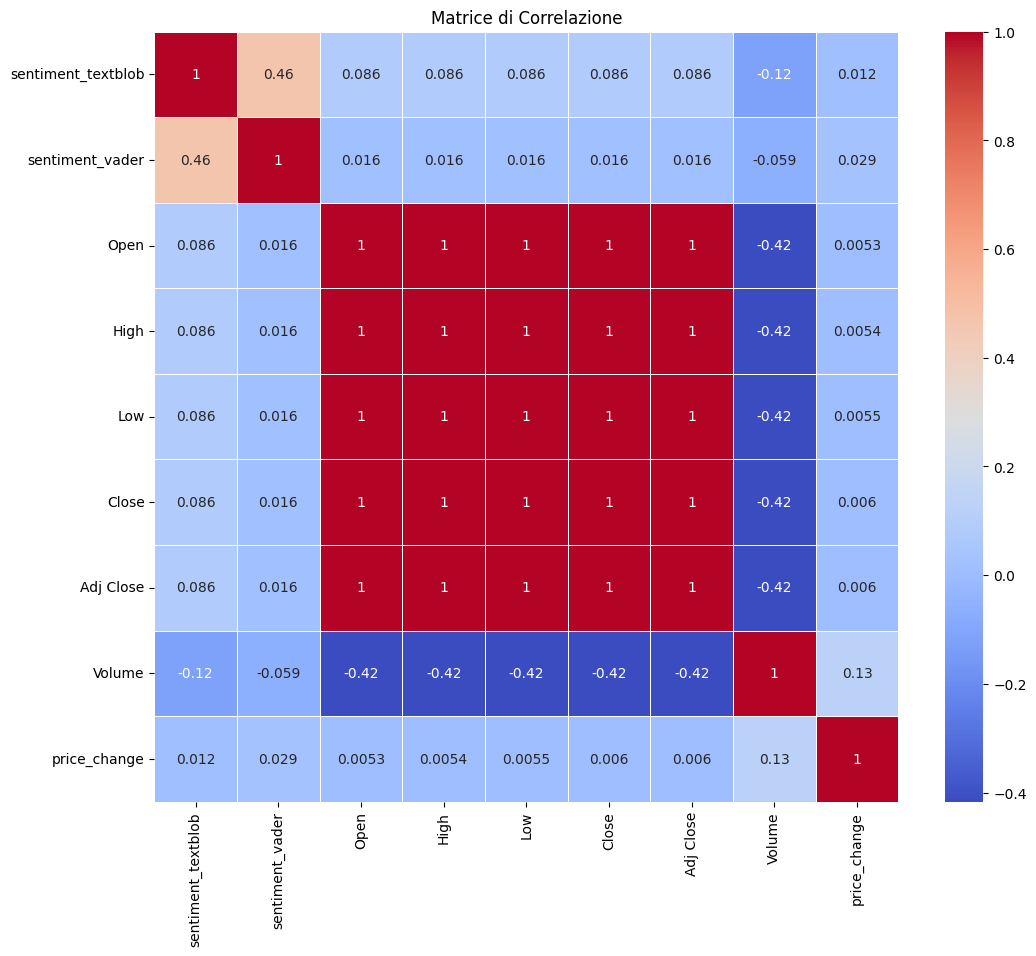

In [95]:
# Visualizza la matrice di correlazione
plot_correlation_matrix(merged_df)

## 5. Tags Classification

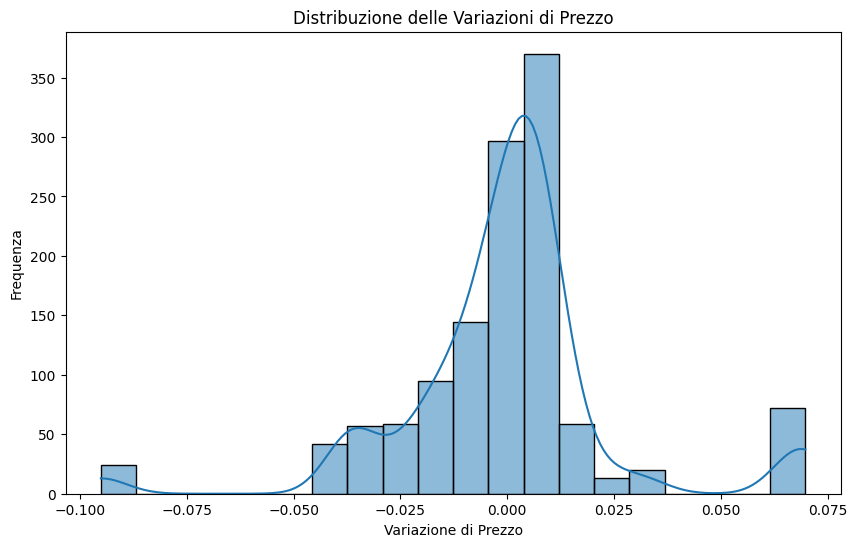

In [96]:
# # Controlla le prime righe delle variazioni di prezzo per verificare i calcoli
# print(merged_df[['date', 'symbol', 'Close', 'price_change']].head(50))

# # Statistiche descrittive delle variazioni di prezzo
# print(merged_df['price_change'].describe())

# Controlla la distribuzione delle variazioni di prezzo
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['price_change'], bins=20, kde=True)
plt.title('Distribuzione delle Variazioni di Prezzo')
plt.xlabel('Variazione di Prezzo')
plt.ylabel('Frequenza')
plt.show()

In [97]:
# Verifica della distribuzione delle variazioni di prezzo
print(merged_df['price_change'].value_counts(bins=10))

# Verifica delle statistiche delle variazioni di prezzo
print(merged_df['price_change'].describe())

(-0.0127, 0.00383]    441
(0.00383, 0.0203]     429
(-0.0292, -0.0127]    154
(-0.0457, -0.0292]     99
(0.0533, 0.0698]       72
(0.0203, 0.0368]       33
(-0.0963, -0.0786]     24
(-0.0786, -0.0621]      0
(-0.0621, -0.0457]      0
(0.0368, 0.0533]        0
Name: count, dtype: int64
count   1252.00000000
mean      -0.00003682
std        0.02542600
min       -0.09513181
25%       -0.00826540
50%        0.00106900
75%        0.00805754
max        0.06980442
Name: price_change, dtype: float64


In [98]:
merged_df['date'].value_counts()

date
2024-05-30    130
2024-05-28    128
2024-05-29    112
2024-05-21    107
2024-05-23    100
2024-05-24     93
2024-05-22     79
2024-05-20     72
2024-05-07     34
2024-05-17     34
2024-05-06     34
2024-05-16     33
2024-05-15     27
2024-05-08     25
2024-04-23     19
2024-05-03     18
2024-05-14     17
2024-05-13     15
2024-05-01     15
2024-04-17     14
2024-04-29     13
2024-05-02     13
2024-05-09     13
2024-04-24     12
2024-04-30     10
2024-04-22     10
2024-04-18     10
2024-04-26      9
2024-04-15      8
2024-04-25      8
2024-04-19      8
2024-05-10      7
2024-04-16      6
2024-04-12      6
2024-04-11      4
2024-04-10      4
2024-04-08      3
2024-04-09      1
2024-04-05      1
Name: count, dtype: int64

In this step, we create labels for the stock price changes in our merged dataset. We define a threshold to determine what constitutes a significant price change, 1%. If the price change exceeds the positive threshold, it is labeled as 'positive'. If the price change falls below the negative threshold, it is labeled as ‘negative’. Any price changes that fall within the threshold range are labeled as ‘no_change’.

In [99]:
threshold = 0.02 

# Labels based on the price change
merged_df['label'] = np.select(
    [
        (merged_df['price_change'] > threshold),  # Significant positive change
        (merged_df['price_change'] < -threshold)  # Significant negative change
    ],
    [
        'positive', # Label for positive change
        'negative'  # Label for negative change
    ],
    default='no_change' # Label for no significant change
)

In [100]:
merged_df['label'].value_counts()

label
no_change    962
negative     185
positive     105
Name: count, dtype: int64

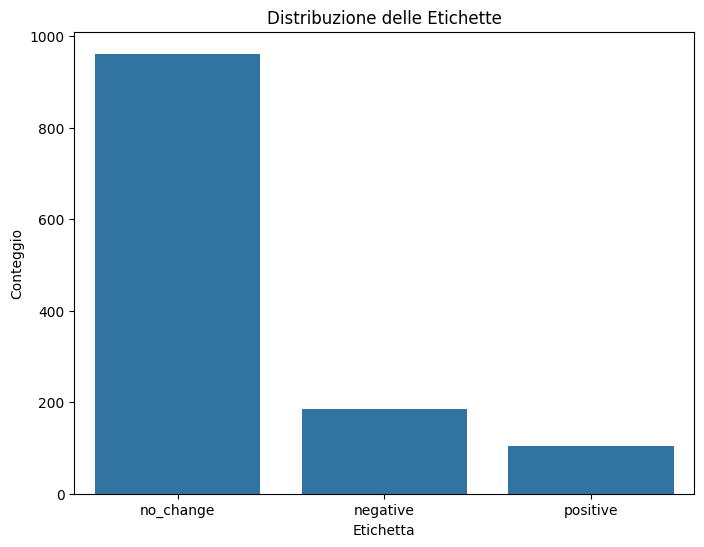

In [101]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=merged_df)
plt.title('Distribuzione delle Etichette')
plt.xlabel('Etichetta')
plt.ylabel('Conteggio')
plt.show()

## 6. Machine Learning Models

We prepare the features and labels for our machine learning models. We select relevant features from the merged dataset, which include the sentiment scores derived from TextBlob and VADER sentiment analysis. 

In [102]:
# Select features: sentiment scores from TextBlob and VADER
X = merged_df[['sentiment_textblob', 'sentiment_vader']]
# Select labels: stock price movement labels
y = merged_df['label']

We also encode the labels into numerical format. Since our models require numerical labels, we use LabelEncoder from scikit-learn to transform the categorical labels (‘positive’, ‘negative’, ‘no_change’) into integer values. This process ensures that the labels are in a suitable format for model training.

LabelEncoder will encode the labels in alphabetical order:
- ‘negative’ -> 0
- ‘no_change’ -> 1
- ‘positive’ -> 2

In [103]:
# Encode labels as integer values
le = LabelEncoder()
y = le.fit_transform(y)

In [104]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'negative': 0, 'no_change': 1, 'positive': 2}

This code prepares the data for the subsequent training and evaluation of machine learning models, which will use these standardized training, validation, and test sets to build and validate predictive models.

We split the dataset into training, validation, and test sets, and then normalizes the features using standardization. 	The validation set is used to tune the model’s hyperparameters and prevent overfitting and the test set is used to evaluate the final performance of the model.

Standardization is performed to normalize the features, ensuring that they have a mean of 0 and a standard deviation of 1. This is important for many machine learning algorithms, which perform better when the input features are on the same scale.

This process of splitting and standardizing the data ensures that the machine learning models we train will be evaluated fairly and consistently. The validation set helps in tuning and preventing overfitting, while the test set provides a final unbiased evaluation of the model. Standardization ensures that all features contribute equally to the model, improving its performance and convergence speed.

In [105]:
# Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the 3 data sets and transform it
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We initialize a set of traditional machine learning models. 
<br>

1. **Logistic Regression**<br>
A linear model used for binary classification tasks. It models the probability of a class based on the input features.<br>
2. **Support Vector Machine (SVM)**<br>
A powerful classification method that finds the hyperplane that best separates the classes in the feature space.
3. **Random Forest**<br>
An ensemble method that constructs multiple decision trees during training and outputs the mode of the classes for classification.
4. **Gradient Boosting**<br>
Another ensemble method that builds models sequentially, each trying to correct the errors of the previous one, effectively boosting performance.
5. **Decision Tree**<br>
A simple and interpretable model that splits the data based on feature values to make classifications.
6. **K-Nearest Neighbors (KNN)**<br>
A non-parametric method that classifies a data point based on how its neighbors are classified.
7. **Naive Bayes**<br>
A probabilistic classifier based on Bayes’ theorem, assuming independence between the features.
8. **XGBoost**<br>
An efficient and scalable implementation of gradient boosting, which is often used in competitions for its high performance.


Each of these models represents a different approach to classification, providing a variety of methods to handle our sentiment analysis and price prediction task. By comparing these models, we can determine which one performs best for our specific problem.
These models will be trained, validated, and compared to identify the best-performing model for predicting stock price movements based on news sentiment.

In [106]:
# Initializing traditional machine learning models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

This function was created to train and evaluate a the set of machine learning models defined previously on the training and validation datasets. It takes the initialized models, training features, training labels, validation features, and validation labels as inputs, and returns the evaluation results.

In [107]:
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    # Dictionary to store the performance metrics for each model
    results = {}
    for name, model in models.items():
        # Train the model with the training data
        model.fit(X_train, y_train)
        # Predictions using the validation data
        y_pred = model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        results[name] = {
            "accuracy": accuracy,
            "report": report
        }
        
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_val, y_pred, zero_division=0))
        print("-" * 60)
    return results

In [108]:
results = train_and_evaluate(models, X_train, y_train, X_val, y_val)

Model: Logistic Regression
Accuracy: 0.776
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.78      1.00      0.87       194
           2       0.00      0.00      0.00        25

    accuracy                           0.78       250
   macro avg       0.26      0.33      0.29       250
weighted avg       0.60      0.78      0.68       250

------------------------------------------------------------
Model: SVM
Accuracy: 0.776
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.78      1.00      0.87       194
           2       0.00      0.00      0.00        25

    accuracy                           0.78       250
   macro avg       0.26      0.33      0.29       250
weighted avg       0.60      0.78      0.68       250

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.72
          

The results indicate that all the models perform well in classifying instances of class 1, but they struggle significantly with classes 0 and 2. This consistent high performance on the dominant class (class 1) and poor performance on the minority classes (0 and 2) suggest a potential issue with class imbalance. The models’ inability to generalize well on classes 0 and 2 may indicate overfitting to the majority class. The models have likely learned to predict the dominant class (class 1) effectively but have not learned to differentiate between the minority classes due to insufficient representation in the training data.

<br>

To address this issue, we will balance the dataset using techniques like SMOTE (Synthetic Minority Over-sampling Technique). Balancing the dataset should help the models learn to identify patterns in the minority classes better, potentially improving their performance on these classes.

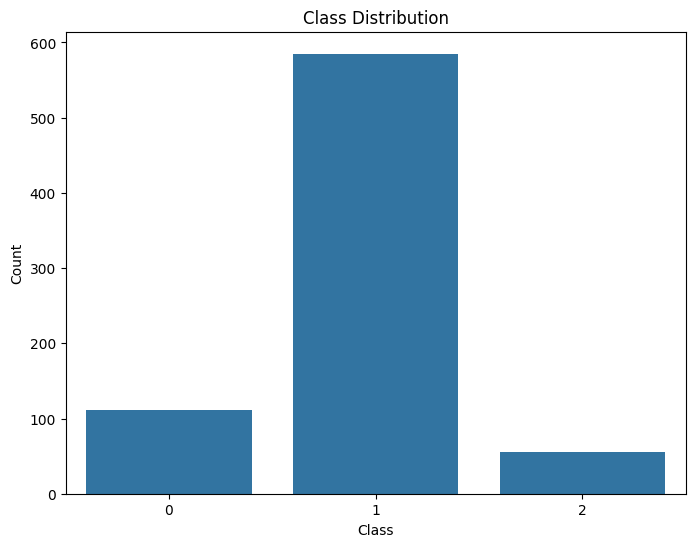

In [109]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [110]:
# Applies SMOTE to balance the class distribution in the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

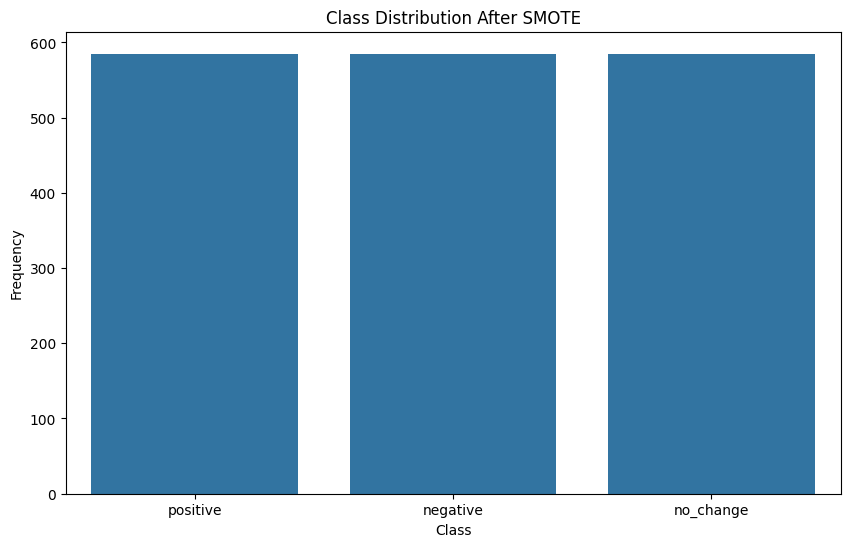

In [111]:
unique, counts = np.unique(y_train_res, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['positive', 'negative', 'no_change'])
plt.show()


In [112]:
results = train_and_evaluate(models, X_train_res, y_train_res, X_val, y_val)

Model: Logistic Regression
Accuracy: 0.304
              precision    recall  f1-score   support

           0       0.12      0.23      0.16        31
           1       0.85      0.27      0.41       194
           2       0.12      0.64      0.21        25

    accuracy                           0.30       250
   macro avg       0.37      0.38      0.26       250
weighted avg       0.69      0.30      0.36       250

------------------------------------------------------------
Model: SVM
Accuracy: 0.292
              precision    recall  f1-score   support

           0       0.16      0.68      0.26        31
           1       0.84      0.25      0.38       194
           2       0.07      0.16      0.09        25

    accuracy                           0.29       250
   macro avg       0.36      0.36      0.24       250
weighted avg       0.68      0.29      0.34       250

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.4
           

After applying SMOTE to balance the dataset, we observe a noticeable shift in the performance of the models. Previously, the models primarily focused on classifying the majority class accurately. However, post-SMOTE, the models now attempt to balance the classification across all three classes, resulting in different performance metrics.

In general, the accuracy of the models has decreased. This drop in accuracy is expected as the models now face a more balanced but challenging classification task. They are no longer biased towards the majority class and are making predictions across all classes, which was the intended outcome of applying SMOTE.

This decrease in overall accuracy and increase in the attempt to classify minority classes indicates that our models are now more balanced. They are not simply predicting the majority class but are also considering the minority classes. This is evident from the precision and recall values for classes 0 and 2, which were previously ignored.

In this section of the code we identify, train, and evaluate the best-performing machine learning model from the previous step.

In [113]:
# Find the model with the highest accuracy
best_model_name = max(results, key=lambda name: results[name]["accuracy"])
best_model = models[best_model_name]

In [114]:
# Train the best model on the combined training and validation sets
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

# Fit the model to the combined training data
best_model.fit(X_train_full, y_train_full)

# Prediction, accuracy calculation, classification report
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, zero_division=0)

In [115]:
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy}")
print(test_report)

Best Model: KNN
Test Accuracy: 0.7091633466135459
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.73      0.97      0.83       183
           2       0.00      0.00      0.00        25

    accuracy                           0.71       251
   macro avg       0.24      0.32      0.28       251
weighted avg       0.53      0.71      0.61       251



## Hugging Face

We have explored various traditional machine learning algorithms. Despite some success, the models have shown limitations, particularly in handling class imbalances and achieving high performance across all classes.

To address these challenges, we turn to advanced natural language processing techniques, leveraging Hugging Face's pre-trained transformer models. These models, such as BERT, are renowned for their state-of-the-art performance in various NLP tasks. By fine-tuning a pre-trained BERT model on our specific dataset, we aim to:

1. **Improve Text Understanding:** Transformers are highly effective in capturing the context and semantics of text, which can lead to better sentiment analysis and feature extraction.
2. **Handle Class Imbalance:** The pre-trained models have been trained on massive datasets, providing a strong foundation that can be fine-tuned to better handle our imbalanced dataset.
3. **Enhance Predictive Accuracy:** By leveraging advanced architectures, we expect to achieve higher accuracy and more balanced performance across all classes.

The following sections detail the implementation, training, and evaluation of the Hugging Face model, along with comparisons to the traditional machine learning models.

This class defines a custom dataset class for use with Hugging Face’s transformer models. By creating a NewsDataset class, we can prepare our data in a format compatible with the transformers library and PyTorch’s data loading utilities, facilitating efficient training and evaluation.

In [116]:
# Function to create a custom dataset for Hugging Face
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [117]:
# Tokenization of texts
# DistilBertTokenizer from the Hugging Face transformers library is initialized with the pre-trained distilbert-base-uncased model. 
# The distilbert-base-uncased tokenizer specifically lowercases the text and splits it into subword tokens.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [118]:
# Maintain the original indices
indices = np.arange(len(merged_df))

In [119]:
# Splitting the data as traditional models, retaining indices
X_train, X_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(merged_df['cleaned_title'], y, indices, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, val_indices, test_indices = train_test_split(X_temp, y_temp, temp_indices, test_size=0.5, random_state=42)

In [120]:
# Tokenize the data separately for train, val, and test sets
encodings_train = tokenizer(list(X_train), truncation=True, padding=True)
encodings_val = tokenizer(list(X_val), truncation=True, padding=True)
encodings_test = tokenizer(list(X_test), truncation=True, padding=True)

In [121]:
# Create datasets
train_dataset = NewsDataset(encodings_train, y_train)
val_dataset = NewsDataset(encodings_val, y_val)
test_dataset = NewsDataset(encodings_test, y_test)

In [122]:
# Load the DistilBertForSequenceClassification pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [123]:
# Training settings
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=50,                # Number of training epochs
    per_device_train_batch_size=32,     # Batch size for training
    per_device_eval_batch_size=32,      # Batch size for evaluation
    warmup_steps=500,                   # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

In [124]:
# Creation of the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


In [125]:
# Addestramento del modello
trainer.train()

  0%|          | 0/1200 [00:00<?, ?it/s]

  1%|          | 11/1200 [00:01<01:40, 11.84it/s]

{'loss': 1.1492, 'grad_norm': 4.13704776763916, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.42}


  2%|▏         | 21/1200 [00:01<01:35, 12.41it/s]

{'loss': 1.1248, 'grad_norm': 3.4801528453826904, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.83}


  2%|▏         | 25/1200 [00:03<05:17,  3.70it/s]

{'eval_loss': 1.0934655666351318, 'eval_runtime': 0.253, 'eval_samples_per_second': 988.279, 'eval_steps_per_second': 31.625, 'epoch': 1.0}


  3%|▎         | 31/1200 [00:03<02:51,  6.83it/s]

{'loss': 1.0873, 'grad_norm': 4.280001640319824, 'learning_rate': 3e-06, 'epoch': 1.25}


  3%|▎         | 41/1200 [00:04<01:46, 10.83it/s]

{'loss': 1.0393, 'grad_norm': 3.795818567276001, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.67}


  4%|▍         | 50/1200 [00:05<01:52, 10.23it/s]

{'eval_loss': 0.9131958484649658, 'eval_runtime': 0.1132, 'eval_samples_per_second': 2208.365, 'eval_steps_per_second': 70.668, 'epoch': 2.0}
{'loss': 0.9508, 'grad_norm': 3.0816915035247803, 'learning_rate': 5e-06, 'epoch': 2.08}


  5%|▌         | 61/1200 [00:06<01:33, 12.18it/s]

{'loss': 0.8224, 'grad_norm': 2.113642454147339, 'learning_rate': 6e-06, 'epoch': 2.5}


  6%|▌         | 71/1200 [00:07<01:30, 12.51it/s]

{'loss': 0.7114, 'grad_norm': 2.0789647102355957, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.92}



  6%|▌         | 73/1200 [00:07<01:45, 10.67it/s]

{'eval_loss': 0.6833901405334473, 'eval_runtime': 0.1127, 'eval_samples_per_second': 2218.514, 'eval_steps_per_second': 70.992, 'epoch': 3.0}


  7%|▋         | 81/1200 [00:08<01:33, 12.01it/s]

{'loss': 0.6661, 'grad_norm': 1.4102897644042969, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.33}


  8%|▊         | 91/1200 [00:08<01:30, 12.30it/s]

{'loss': 0.6842, 'grad_norm': 2.7600696086883545, 'learning_rate': 9e-06, 'epoch': 3.75}


  8%|▊         | 97/1200 [00:09<01:44, 10.55it/s]

{'eval_loss': 0.6813734173774719, 'eval_runtime': 0.113, 'eval_samples_per_second': 2213.311, 'eval_steps_per_second': 70.826, 'epoch': 4.0}


  8%|▊         | 101/1200 [00:09<01:36, 11.37it/s]

{'loss': 0.57, 'grad_norm': 1.18405020236969, 'learning_rate': 1e-05, 'epoch': 4.17}


  9%|▉         | 111/1200 [00:10<01:29, 12.14it/s]

{'loss': 0.6285, 'grad_norm': 1.3581429719924927, 'learning_rate': 1.1000000000000001e-05, 'epoch': 4.58}


 10%|█         | 120/1200 [00:11<01:27, 12.30it/s]

{'loss': 0.6585, 'grad_norm': 2.9247705936431885, 'learning_rate': 1.2e-05, 'epoch': 5.0}



 10%|█         | 121/1200 [00:11<01:43, 10.43it/s]

{'eval_loss': 0.664352536201477, 'eval_runtime': 0.1138, 'eval_samples_per_second': 2197.093, 'eval_steps_per_second': 70.307, 'epoch': 5.0}


 11%|█         | 131/1200 [00:12<01:28, 12.11it/s]

{'loss': 0.6301, 'grad_norm': 4.155295372009277, 'learning_rate': 1.3000000000000001e-05, 'epoch': 5.42}


 12%|█▏        | 141/1200 [00:13<01:25, 12.36it/s]

{'loss': 0.5291, 'grad_norm': 3.2915070056915283, 'learning_rate': 1.4000000000000001e-05, 'epoch': 5.83}


 12%|█▏        | 145/1200 [00:13<01:40, 10.47it/s]

{'eval_loss': 0.6405640840530396, 'eval_runtime': 0.1138, 'eval_samples_per_second': 2196.178, 'eval_steps_per_second': 70.278, 'epoch': 6.0}


 13%|█▎        | 151/1200 [00:14<01:30, 11.56it/s]

{'loss': 0.5949, 'grad_norm': 2.0328779220581055, 'learning_rate': 1.5e-05, 'epoch': 6.25}


 13%|█▎        | 161/1200 [00:14<01:25, 12.10it/s]

{'loss': 0.4909, 'grad_norm': 3.543092727661133, 'learning_rate': 1.6000000000000003e-05, 'epoch': 6.67}


 14%|█▍        | 170/1200 [00:15<01:37, 10.62it/s]

{'eval_loss': 0.6426148414611816, 'eval_runtime': 0.1127, 'eval_samples_per_second': 2217.331, 'eval_steps_per_second': 70.955, 'epoch': 7.0}
{'loss': 0.4869, 'grad_norm': 2.0586462020874023, 'learning_rate': 1.7000000000000003e-05, 'epoch': 7.08}


 15%|█▌        | 181/1200 [00:16<01:24, 12.09it/s]

{'loss': 0.4623, 'grad_norm': 8.478922843933105, 'learning_rate': 1.8e-05, 'epoch': 7.5}


 16%|█▌        | 191/1200 [00:17<01:22, 12.29it/s]

{'loss': 0.4479, 'grad_norm': 4.256146430969238, 'learning_rate': 1.9e-05, 'epoch': 7.92}



 16%|█▌        | 193/1200 [00:17<01:36, 10.45it/s]

{'eval_loss': 0.6886153221130371, 'eval_runtime': 0.1144, 'eval_samples_per_second': 2184.588, 'eval_steps_per_second': 69.907, 'epoch': 8.0}


 17%|█▋        | 201/1200 [00:18<01:23, 11.90it/s]

{'loss': 0.3943, 'grad_norm': 7.723095417022705, 'learning_rate': 2e-05, 'epoch': 8.33}


 18%|█▊        | 211/1200 [00:19<01:20, 12.24it/s]

{'loss': 0.3619, 'grad_norm': 2.8982672691345215, 'learning_rate': 2.1e-05, 'epoch': 8.75}


 18%|█▊        | 217/1200 [00:19<01:33, 10.49it/s]

{'eval_loss': 0.7188518047332764, 'eval_runtime': 0.1136, 'eval_samples_per_second': 2200.455, 'eval_steps_per_second': 70.415, 'epoch': 9.0}


 18%|█▊        | 221/1200 [00:19<01:26, 11.29it/s]

{'loss': 0.3551, 'grad_norm': 4.593660354614258, 'learning_rate': 2.2000000000000003e-05, 'epoch': 9.17}


 19%|█▉        | 231/1200 [00:20<01:19, 12.21it/s]

{'loss': 0.2584, 'grad_norm': 2.2137186527252197, 'learning_rate': 2.3000000000000003e-05, 'epoch': 9.58}


 20%|██        | 240/1200 [00:21<01:16, 12.51it/s]

{'loss': 0.3198, 'grad_norm': 4.046105861663818, 'learning_rate': 2.4e-05, 'epoch': 10.0}



 20%|██        | 241/1200 [00:21<01:30, 10.56it/s]

{'eval_loss': 0.7710779905319214, 'eval_runtime': 0.1155, 'eval_samples_per_second': 2163.98, 'eval_steps_per_second': 69.247, 'epoch': 10.0}


 21%|██        | 251/1200 [00:22<01:19, 11.97it/s]

{'loss': 0.2752, 'grad_norm': 9.34065055847168, 'learning_rate': 2.5e-05, 'epoch': 10.42}


 22%|██▏       | 261/1200 [00:23<01:16, 12.29it/s]

{'loss': 0.2598, 'grad_norm': 3.5468692779541016, 'learning_rate': 2.6000000000000002e-05, 'epoch': 10.83}


 22%|██▏       | 265/1200 [00:23<01:28, 10.51it/s]

{'eval_loss': 0.8637691140174866, 'eval_runtime': 0.1132, 'eval_samples_per_second': 2208.83, 'eval_steps_per_second': 70.683, 'epoch': 11.0}


 23%|██▎       | 271/1200 [00:24<01:19, 11.74it/s]

{'loss': 0.1917, 'grad_norm': 1.7251083850860596, 'learning_rate': 2.7000000000000002e-05, 'epoch': 11.25}


 23%|██▎       | 281/1200 [00:25<01:14, 12.35it/s]

{'loss': 0.1754, 'grad_norm': 5.31013298034668, 'learning_rate': 2.8000000000000003e-05, 'epoch': 11.67}


 24%|██▍       | 290/1200 [00:25<01:26, 10.47it/s]

{'eval_loss': 0.7734520435333252, 'eval_runtime': 0.1157, 'eval_samples_per_second': 2160.573, 'eval_steps_per_second': 69.138, 'epoch': 12.0}
{'loss': 0.306, 'grad_norm': 4.222005844116211, 'learning_rate': 2.9e-05, 'epoch': 12.08}


 25%|██▌       | 301/1200 [00:26<01:18, 11.40it/s]

{'loss': 0.1807, 'grad_norm': 2.3176016807556152, 'learning_rate': 3e-05, 'epoch': 12.5}


 26%|██▌       | 311/1200 [00:27<01:14, 11.95it/s]

{'loss': 0.2172, 'grad_norm': 2.2066354751586914, 'learning_rate': 3.1e-05, 'epoch': 12.92}



 26%|██▌       | 313/1200 [00:27<01:27, 10.11it/s]

{'eval_loss': 1.0037522315979004, 'eval_runtime': 0.1208, 'eval_samples_per_second': 2069.385, 'eval_steps_per_second': 66.22, 'epoch': 13.0}


 27%|██▋       | 321/1200 [00:28<01:15, 11.65it/s]

{'loss': 0.1467, 'grad_norm': 0.834750771522522, 'learning_rate': 3.2000000000000005e-05, 'epoch': 13.33}


 28%|██▊       | 331/1200 [00:29<01:13, 11.85it/s]

{'loss': 0.2149, 'grad_norm': 4.545413970947266, 'learning_rate': 3.3e-05, 'epoch': 13.75}


 28%|██▊       | 337/1200 [00:29<01:25, 10.13it/s]

{'eval_loss': 0.8812985420227051, 'eval_runtime': 0.1169, 'eval_samples_per_second': 2138.049, 'eval_steps_per_second': 68.418, 'epoch': 14.0}


 28%|██▊       | 341/1200 [00:30<01:18, 11.01it/s]

{'loss': 0.1177, 'grad_norm': 0.4369184970855713, 'learning_rate': 3.4000000000000007e-05, 'epoch': 14.17}


 29%|██▉       | 351/1200 [00:31<01:12, 11.71it/s]

{'loss': 0.0948, 'grad_norm': 2.1132328510284424, 'learning_rate': 3.5e-05, 'epoch': 14.58}


 30%|███       | 360/1200 [00:31<01:11, 11.76it/s]

{'loss': 0.1868, 'grad_norm': 4.606054782867432, 'learning_rate': 3.6e-05, 'epoch': 15.0}



 30%|███       | 360/1200 [00:32<01:11, 11.76it/s]

{'eval_loss': 1.086198329925537, 'eval_runtime': 0.1202, 'eval_samples_per_second': 2080.025, 'eval_steps_per_second': 66.561, 'epoch': 15.0}


 31%|███       | 371/1200 [00:32<01:12, 11.44it/s]

{'loss': 0.0678, 'grad_norm': 2.8003265857696533, 'learning_rate': 3.7e-05, 'epoch': 15.42}


 32%|███▏      | 381/1200 [00:33<01:10, 11.66it/s]

{'loss': 0.18, 'grad_norm': 3.5581986904144287, 'learning_rate': 3.8e-05, 'epoch': 15.83}


 32%|███▏      | 385/1200 [00:34<01:21, 10.02it/s]

{'eval_loss': 1.0883561372756958, 'eval_runtime': 0.1193, 'eval_samples_per_second': 2095.095, 'eval_steps_per_second': 67.043, 'epoch': 16.0}


 33%|███▎      | 391/1200 [00:34<01:13, 11.06it/s]

{'loss': 0.0863, 'grad_norm': 3.71077036857605, 'learning_rate': 3.9000000000000006e-05, 'epoch': 16.25}


 33%|███▎      | 401/1200 [00:35<01:06, 11.96it/s]

{'loss': 0.1186, 'grad_norm': 6.3301520347595215, 'learning_rate': 4e-05, 'epoch': 16.67}


 34%|███▍      | 410/1200 [00:36<01:17, 10.14it/s]

{'eval_loss': 1.1821118593215942, 'eval_runtime': 0.1184, 'eval_samples_per_second': 2111.077, 'eval_steps_per_second': 67.554, 'epoch': 17.0}
{'loss': 0.1154, 'grad_norm': 2.96677565574646, 'learning_rate': 4.1e-05, 'epoch': 17.08}


 35%|███▌      | 421/1200 [00:37<01:07, 11.57it/s]

{'loss': 0.0796, 'grad_norm': 1.175217866897583, 'learning_rate': 4.2e-05, 'epoch': 17.5}


 36%|███▌      | 431/1200 [00:38<01:04, 11.88it/s]

{'loss': 0.1132, 'grad_norm': 0.6513102054595947, 'learning_rate': 4.3e-05, 'epoch': 17.92}



 36%|███▌      | 433/1200 [00:38<01:15, 10.13it/s]

{'eval_loss': 1.1705769300460815, 'eval_runtime': 0.1185, 'eval_samples_per_second': 2109.599, 'eval_steps_per_second': 67.507, 'epoch': 18.0}


 37%|███▋      | 441/1200 [00:39<01:06, 11.35it/s]

{'loss': 0.0713, 'grad_norm': 1.8301336765289307, 'learning_rate': 4.4000000000000006e-05, 'epoch': 18.33}


 38%|███▊      | 451/1200 [00:39<01:01, 12.10it/s]

{'loss': 0.0951, 'grad_norm': 2.979517698287964, 'learning_rate': 4.5e-05, 'epoch': 18.75}


 38%|███▊      | 457/1200 [00:40<01:10, 10.54it/s]

{'eval_loss': 1.165339469909668, 'eval_runtime': 0.1115, 'eval_samples_per_second': 2242.353, 'eval_steps_per_second': 71.755, 'epoch': 19.0}


 38%|███▊      | 461/1200 [00:40<01:06, 11.09it/s]

{'loss': 0.0547, 'grad_norm': 0.5462222695350647, 'learning_rate': 4.600000000000001e-05, 'epoch': 19.17}


 39%|███▉      | 471/1200 [00:41<01:02, 11.65it/s]

{'loss': 0.0447, 'grad_norm': 0.22393746674060822, 'learning_rate': 4.7e-05, 'epoch': 19.58}


 40%|████      | 480/1200 [00:42<01:00, 11.86it/s]

{'loss': 0.1361, 'grad_norm': 3.0505239963531494, 'learning_rate': 4.8e-05, 'epoch': 20.0}



 40%|████      | 480/1200 [00:42<01:00, 11.86it/s]

{'eval_loss': 1.21394681930542, 'eval_runtime': 0.1172, 'eval_samples_per_second': 2133.385, 'eval_steps_per_second': 68.268, 'epoch': 20.0}


 41%|████      | 491/1200 [00:43<00:58, 12.02it/s]

{'loss': 0.0572, 'grad_norm': 1.1705756187438965, 'learning_rate': 4.9e-05, 'epoch': 20.42}


 42%|████▏     | 500/1200 [00:44<00:56, 12.38it/s]

{'loss': 0.0567, 'grad_norm': 0.2775838375091553, 'learning_rate': 5e-05, 'epoch': 20.83}


 42%|████▏     | 505/1200 [00:45<02:00,  5.75it/s]

{'eval_loss': 1.3564482927322388, 'eval_runtime': 0.1129, 'eval_samples_per_second': 2213.68, 'eval_steps_per_second': 70.838, 'epoch': 21.0}


 43%|████▎     | 511/1200 [00:46<01:18,  8.72it/s]

{'loss': 0.0596, 'grad_norm': 0.29799318313598633, 'learning_rate': 4.928571428571429e-05, 'epoch': 21.25}


 43%|████▎     | 521/1200 [00:47<01:01, 11.04it/s]

{'loss': 0.079, 'grad_norm': 0.5266186594963074, 'learning_rate': 4.8571428571428576e-05, 'epoch': 21.67}


 44%|████▍     | 530/1200 [00:48<01:08,  9.71it/s]

{'eval_loss': 1.3895056247711182, 'eval_runtime': 0.1186, 'eval_samples_per_second': 2107.466, 'eval_steps_per_second': 67.439, 'epoch': 22.0}
{'loss': 0.0406, 'grad_norm': 2.796123504638672, 'learning_rate': 4.785714285714286e-05, 'epoch': 22.08}


 45%|████▌     | 541/1200 [00:48<00:57, 11.44it/s]

{'loss': 0.0376, 'grad_norm': 0.12187264114618301, 'learning_rate': 4.714285714285714e-05, 'epoch': 22.5}


 46%|████▌     | 551/1200 [00:49<00:54, 11.85it/s]

{'loss': 0.0738, 'grad_norm': 0.9947227239608765, 'learning_rate': 4.642857142857143e-05, 'epoch': 22.92}



 46%|████▌     | 553/1200 [00:50<01:03, 10.15it/s]

{'eval_loss': 1.450716495513916, 'eval_runtime': 0.1148, 'eval_samples_per_second': 2178.42, 'eval_steps_per_second': 69.709, 'epoch': 23.0}


 47%|████▋     | 561/1200 [00:50<00:55, 11.47it/s]

{'loss': 0.0654, 'grad_norm': 0.5372748970985413, 'learning_rate': 4.5714285714285716e-05, 'epoch': 23.33}


 48%|████▊     | 571/1200 [00:51<00:53, 11.86it/s]

{'loss': 0.0811, 'grad_norm': 1.2846145629882812, 'learning_rate': 4.5e-05, 'epoch': 23.75}


 48%|████▊     | 577/1200 [00:52<01:01, 10.09it/s]

{'eval_loss': 1.4019824266433716, 'eval_runtime': 0.12, 'eval_samples_per_second': 2083.77, 'eval_steps_per_second': 66.681, 'epoch': 24.0}


 48%|████▊     | 581/1200 [00:52<00:56, 11.02it/s]

{'loss': 0.0529, 'grad_norm': 1.2327347993850708, 'learning_rate': 4.428571428571428e-05, 'epoch': 24.17}


 49%|████▉     | 591/1200 [00:53<00:50, 12.06it/s]

{'loss': 0.0742, 'grad_norm': 0.49846917390823364, 'learning_rate': 4.3571428571428576e-05, 'epoch': 24.58}


 50%|█████     | 600/1200 [00:54<00:49, 12.08it/s]

{'loss': 0.0238, 'grad_norm': 0.5123704671859741, 'learning_rate': 4.2857142857142856e-05, 'epoch': 25.0}



 50%|█████     | 601/1200 [00:54<00:58, 10.30it/s]

{'eval_loss': 1.537405014038086, 'eval_runtime': 0.1151, 'eval_samples_per_second': 2171.801, 'eval_steps_per_second': 69.498, 'epoch': 25.0}


 51%|█████     | 611/1200 [00:55<00:49, 11.94it/s]

{'loss': 0.0316, 'grad_norm': 0.5026838183403015, 'learning_rate': 4.214285714285714e-05, 'epoch': 25.42}


 52%|█████▏    | 621/1200 [00:55<00:46, 12.41it/s]

{'loss': 0.0551, 'grad_norm': 0.1659672111272812, 'learning_rate': 4.1428571428571437e-05, 'epoch': 25.83}


 52%|█████▏    | 625/1200 [00:56<00:54, 10.46it/s]

{'eval_loss': 1.5247141122817993, 'eval_runtime': 0.1143, 'eval_samples_per_second': 2187.131, 'eval_steps_per_second': 69.988, 'epoch': 26.0}


 53%|█████▎    | 631/1200 [00:56<00:49, 11.58it/s]

{'loss': 0.0308, 'grad_norm': 0.30632710456848145, 'learning_rate': 4.0714285714285717e-05, 'epoch': 26.25}


 53%|█████▎    | 641/1200 [00:57<00:46, 12.15it/s]

{'loss': 0.0335, 'grad_norm': 0.1381588727235794, 'learning_rate': 4e-05, 'epoch': 26.67}


 54%|█████▍    | 650/1200 [00:58<00:52, 10.45it/s]

{'eval_loss': 1.623136043548584, 'eval_runtime': 0.1135, 'eval_samples_per_second': 2202.854, 'eval_steps_per_second': 70.491, 'epoch': 27.0}
{'loss': 0.065, 'grad_norm': 0.30120059847831726, 'learning_rate': 3.928571428571429e-05, 'epoch': 27.08}


 55%|█████▌    | 661/1200 [00:59<00:45, 11.96it/s]

{'loss': 0.0356, 'grad_norm': 0.02612532675266266, 'learning_rate': 3.857142857142858e-05, 'epoch': 27.5}


 56%|█████▌    | 671/1200 [01:00<00:42, 12.33it/s]

{'loss': 0.0516, 'grad_norm': 0.25375866889953613, 'learning_rate': 3.785714285714286e-05, 'epoch': 27.92}



 56%|█████▌    | 673/1200 [01:00<00:50, 10.48it/s]

{'eval_loss': 1.5237175226211548, 'eval_runtime': 0.1126, 'eval_samples_per_second': 2220.191, 'eval_steps_per_second': 71.046, 'epoch': 28.0}


 57%|█████▋    | 681/1200 [01:00<00:43, 11.82it/s]

{'loss': 0.0732, 'grad_norm': 0.2883415222167969, 'learning_rate': 3.7142857142857143e-05, 'epoch': 28.33}


 58%|█████▊    | 691/1200 [01:01<00:41, 12.26it/s]

{'loss': 0.0261, 'grad_norm': 0.16303600370883942, 'learning_rate': 3.642857142857143e-05, 'epoch': 28.75}


 58%|█████▊    | 697/1200 [01:02<00:47, 10.51it/s]

{'eval_loss': 1.5532407760620117, 'eval_runtime': 0.1135, 'eval_samples_per_second': 2203.381, 'eval_steps_per_second': 70.508, 'epoch': 29.0}


 58%|█████▊    | 701/1200 [01:02<00:43, 11.38it/s]

{'loss': 0.0349, 'grad_norm': 0.025006834417581558, 'learning_rate': 3.571428571428572e-05, 'epoch': 29.17}


 59%|█████▉    | 711/1200 [01:03<00:40, 12.07it/s]

{'loss': 0.0347, 'grad_norm': 0.7697718143463135, 'learning_rate': 3.5e-05, 'epoch': 29.58}


 60%|██████    | 720/1200 [01:04<00:39, 12.14it/s]

{'loss': 0.0415, 'grad_norm': 0.730957567691803, 'learning_rate': 3.428571428571429e-05, 'epoch': 30.0}



 60%|██████    | 720/1200 [01:04<00:39, 12.14it/s]

{'eval_loss': 1.583211898803711, 'eval_runtime': 0.1151, 'eval_samples_per_second': 2171.082, 'eval_steps_per_second': 69.475, 'epoch': 30.0}


 61%|██████    | 731/1200 [01:05<00:40, 11.72it/s]

{'loss': 0.0412, 'grad_norm': 0.4783695340156555, 'learning_rate': 3.357142857142857e-05, 'epoch': 30.42}


 62%|██████▏   | 741/1200 [01:06<00:37, 12.16it/s]

{'loss': 0.0349, 'grad_norm': 0.6130709648132324, 'learning_rate': 3.285714285714286e-05, 'epoch': 30.83}


 62%|██████▏   | 745/1200 [01:06<00:43, 10.47it/s]

{'eval_loss': 1.6072696447372437, 'eval_runtime': 0.1125, 'eval_samples_per_second': 2222.185, 'eval_steps_per_second': 71.11, 'epoch': 31.0}


 63%|██████▎   | 751/1200 [01:06<00:38, 11.73it/s]

{'loss': 0.0436, 'grad_norm': 0.012475675903260708, 'learning_rate': 3.2142857142857144e-05, 'epoch': 31.25}


 63%|██████▎   | 761/1200 [01:07<00:37, 11.86it/s]

{'loss': 0.0424, 'grad_norm': 0.5721052289009094, 'learning_rate': 3.142857142857143e-05, 'epoch': 31.67}


 64%|██████▍   | 770/1200 [01:08<00:41, 10.45it/s]

{'eval_loss': 1.6198898553848267, 'eval_runtime': 0.1119, 'eval_samples_per_second': 2235.117, 'eval_steps_per_second': 71.524, 'epoch': 32.0}
{'loss': 0.0264, 'grad_norm': 0.6902672648429871, 'learning_rate': 3.071428571428572e-05, 'epoch': 32.08}


 65%|██████▌   | 781/1200 [01:09<00:34, 12.19it/s]

{'loss': 0.0398, 'grad_norm': 0.43623611330986023, 'learning_rate': 3e-05, 'epoch': 32.5}


 66%|██████▌   | 791/1200 [01:10<00:33, 12.12it/s]

{'loss': 0.0332, 'grad_norm': 0.4299176335334778, 'learning_rate': 2.9285714285714288e-05, 'epoch': 32.92}



 66%|██████▌   | 793/1200 [01:10<00:40, 10.15it/s]

{'eval_loss': 1.66713285446167, 'eval_runtime': 0.1211, 'eval_samples_per_second': 2064.528, 'eval_steps_per_second': 66.065, 'epoch': 33.0}


 67%|██████▋   | 801/1200 [01:11<00:36, 11.08it/s]

{'loss': 0.0416, 'grad_norm': 0.3698981702327728, 'learning_rate': 2.857142857142857e-05, 'epoch': 33.33}


 68%|██████▊   | 811/1200 [01:12<00:34, 11.24it/s]

{'loss': 0.045, 'grad_norm': 0.5705050826072693, 'learning_rate': 2.785714285714286e-05, 'epoch': 33.75}


 68%|██████▊   | 817/1200 [01:12<00:39,  9.63it/s]

{'eval_loss': 1.6522740125656128, 'eval_runtime': 0.123, 'eval_samples_per_second': 2033.018, 'eval_steps_per_second': 65.057, 'epoch': 34.0}


 68%|██████▊   | 821/1200 [01:13<00:35, 10.53it/s]

{'loss': 0.023, 'grad_norm': 0.2435751110315323, 'learning_rate': 2.714285714285714e-05, 'epoch': 34.17}


 69%|██████▉   | 831/1200 [01:13<00:32, 11.46it/s]

{'loss': 0.041, 'grad_norm': 0.6132562756538391, 'learning_rate': 2.642857142857143e-05, 'epoch': 34.58}


 70%|███████   | 840/1200 [01:14<00:30, 11.76it/s]

{'loss': 0.0331, 'grad_norm': 0.008285710588097572, 'learning_rate': 2.5714285714285714e-05, 'epoch': 35.0}



 70%|███████   | 840/1200 [01:14<00:30, 11.76it/s]

{'eval_loss': 1.6721550226211548, 'eval_runtime': 0.1158, 'eval_samples_per_second': 2159.088, 'eval_steps_per_second': 69.091, 'epoch': 35.0}


 71%|███████   | 851/1200 [01:15<00:30, 11.34it/s]

{'loss': 0.0407, 'grad_norm': 0.592069685459137, 'learning_rate': 2.5e-05, 'epoch': 35.42}


 72%|███████▏  | 861/1200 [01:16<00:28, 11.84it/s]

{'loss': 0.0326, 'grad_norm': 0.5971490144729614, 'learning_rate': 2.4285714285714288e-05, 'epoch': 35.83}


 72%|███████▏  | 865/1200 [01:17<00:33, 10.13it/s]

{'eval_loss': 1.7016361951828003, 'eval_runtime': 0.1152, 'eval_samples_per_second': 2169.756, 'eval_steps_per_second': 69.432, 'epoch': 36.0}


 73%|███████▎  | 871/1200 [01:17<00:29, 11.25it/s]

{'loss': 0.0272, 'grad_norm': 0.008665977977216244, 'learning_rate': 2.357142857142857e-05, 'epoch': 36.25}


 73%|███████▎  | 881/1200 [01:18<00:27, 11.70it/s]

{'loss': 0.049, 'grad_norm': 0.3348686993122101, 'learning_rate': 2.2857142857142858e-05, 'epoch': 36.67}


 74%|███████▍  | 890/1200 [01:19<00:30, 10.13it/s]

{'eval_loss': 1.6986937522888184, 'eval_runtime': 0.1143, 'eval_samples_per_second': 2187.683, 'eval_steps_per_second': 70.006, 'epoch': 37.0}
{'loss': 0.0292, 'grad_norm': 0.3395440876483917, 'learning_rate': 2.214285714285714e-05, 'epoch': 37.08}


 75%|███████▌  | 901/1200 [01:20<00:25, 11.62it/s]

{'loss': 0.0347, 'grad_norm': 0.006755365990102291, 'learning_rate': 2.1428571428571428e-05, 'epoch': 37.5}


 76%|███████▌  | 911/1200 [01:21<00:24, 11.78it/s]

{'loss': 0.0367, 'grad_norm': 0.28078049421310425, 'learning_rate': 2.0714285714285718e-05, 'epoch': 37.92}



 76%|███████▌  | 913/1200 [01:21<00:28, 10.17it/s]

{'eval_loss': 1.6945836544036865, 'eval_runtime': 0.1148, 'eval_samples_per_second': 2177.077, 'eval_steps_per_second': 69.666, 'epoch': 38.0}


 77%|███████▋  | 921/1200 [01:21<00:24, 11.53it/s]

{'loss': 0.0361, 'grad_norm': 0.581336259841919, 'learning_rate': 2e-05, 'epoch': 38.33}


 78%|███████▊  | 931/1200 [01:22<00:22, 11.80it/s]

{'loss': 0.0432, 'grad_norm': 0.9612187147140503, 'learning_rate': 1.928571428571429e-05, 'epoch': 38.75}


 78%|███████▊  | 937/1200 [01:23<00:25, 10.19it/s]

{'eval_loss': 1.707747220993042, 'eval_runtime': 0.1146, 'eval_samples_per_second': 2182.451, 'eval_steps_per_second': 69.838, 'epoch': 39.0}


 78%|███████▊  | 941/1200 [01:23<00:23, 11.06it/s]

{'loss': 0.0229, 'grad_norm': 0.4993916153907776, 'learning_rate': 1.8571428571428572e-05, 'epoch': 39.17}


 79%|███████▉  | 951/1200 [01:24<00:21, 11.75it/s]

{'loss': 0.0333, 'grad_norm': 0.40555617213249207, 'learning_rate': 1.785714285714286e-05, 'epoch': 39.58}


 80%|████████  | 960/1200 [01:25<00:19, 12.18it/s]

{'loss': 0.0351, 'grad_norm': 0.009022240526974201, 'learning_rate': 1.7142857142857145e-05, 'epoch': 40.0}



 80%|████████  | 960/1200 [01:25<00:19, 12.18it/s]

{'eval_loss': 1.725146770477295, 'eval_runtime': 0.115, 'eval_samples_per_second': 2173.404, 'eval_steps_per_second': 69.549, 'epoch': 40.0}


 81%|████████  | 971/1200 [01:26<00:19, 11.78it/s]

{'loss': 0.0361, 'grad_norm': 0.5622153878211975, 'learning_rate': 1.642857142857143e-05, 'epoch': 40.42}


 82%|████████▏ | 981/1200 [01:27<00:18, 11.73it/s]

{'loss': 0.0393, 'grad_norm': 0.00714895548298955, 'learning_rate': 1.5714285714285715e-05, 'epoch': 40.83}


 82%|████████▏ | 985/1200 [01:27<00:21, 10.06it/s]

{'eval_loss': 1.7340078353881836, 'eval_runtime': 0.1151, 'eval_samples_per_second': 2172.625, 'eval_steps_per_second': 69.524, 'epoch': 41.0}


 83%|████████▎ | 991/1200 [01:28<00:18, 11.17it/s]

{'loss': 0.0343, 'grad_norm': 0.006894179154187441, 'learning_rate': 1.5e-05, 'epoch': 41.25}


 83%|████████▎ | 1000/1200 [01:28<00:17, 11.74it/s]

{'loss': 0.0276, 'grad_norm': 0.3659570515155792, 'learning_rate': 1.4285714285714285e-05, 'epoch': 41.67}


 84%|████████▍ | 1010/1200 [01:31<00:28,  6.75it/s]

{'eval_loss': 1.742174506187439, 'eval_runtime': 0.1135, 'eval_samples_per_second': 2203.164, 'eval_steps_per_second': 70.501, 'epoch': 42.0}
{'loss': 0.0409, 'grad_norm': 0.663613498210907, 'learning_rate': 1.357142857142857e-05, 'epoch': 42.08}


 85%|████████▌ | 1021/1200 [01:32<00:16, 11.16it/s]

{'loss': 0.0333, 'grad_norm': 0.37743544578552246, 'learning_rate': 1.2857142857142857e-05, 'epoch': 42.5}


 86%|████████▌ | 1031/1200 [01:32<00:14, 12.07it/s]

{'loss': 0.0311, 'grad_norm': 0.03451203927397728, 'learning_rate': 1.2142857142857144e-05, 'epoch': 42.92}



 86%|████████▌ | 1033/1200 [01:33<00:16, 10.09it/s]

{'eval_loss': 1.7457932233810425, 'eval_runtime': 0.1162, 'eval_samples_per_second': 2151.058, 'eval_steps_per_second': 68.834, 'epoch': 43.0}


 87%|████████▋ | 1041/1200 [01:33<00:13, 11.49it/s]

{'loss': 0.042, 'grad_norm': 0.5418621897697449, 'learning_rate': 1.1428571428571429e-05, 'epoch': 43.33}


 88%|████████▊ | 1051/1200 [01:34<00:12, 12.32it/s]

{'loss': 0.0379, 'grad_norm': 0.03258432447910309, 'learning_rate': 1.0714285714285714e-05, 'epoch': 43.75}


 88%|████████▊ | 1057/1200 [01:35<00:13, 10.54it/s]

{'eval_loss': 1.7470511198043823, 'eval_runtime': 0.1133, 'eval_samples_per_second': 2205.736, 'eval_steps_per_second': 70.584, 'epoch': 44.0}


 88%|████████▊ | 1061/1200 [01:35<00:12, 11.24it/s]

{'loss': 0.0408, 'grad_norm': 0.3771124482154846, 'learning_rate': 1e-05, 'epoch': 44.17}


 89%|████████▉ | 1071/1200 [01:36<00:10, 12.25it/s]

{'loss': 0.0185, 'grad_norm': 0.0076780980452895164, 'learning_rate': 9.285714285714286e-06, 'epoch': 44.58}


 90%|█████████ | 1080/1200 [01:37<00:09, 12.44it/s]

{'loss': 0.0461, 'grad_norm': 0.5283041596412659, 'learning_rate': 8.571428571428573e-06, 'epoch': 45.0}



 90%|█████████ | 1081/1200 [01:37<00:11, 10.56it/s]

{'eval_loss': 1.7501581907272339, 'eval_runtime': 0.1142, 'eval_samples_per_second': 2189.752, 'eval_steps_per_second': 70.072, 'epoch': 45.0}


 91%|█████████ | 1091/1200 [01:38<00:09, 12.05it/s]

{'loss': 0.0234, 'grad_norm': 0.5672798156738281, 'learning_rate': 7.857142857142858e-06, 'epoch': 45.42}


 92%|█████████▏| 1101/1200 [01:38<00:07, 12.44it/s]

{'loss': 0.0454, 'grad_norm': 0.012312807142734528, 'learning_rate': 7.142857142857143e-06, 'epoch': 45.83}


 92%|█████████▏| 1105/1200 [01:39<00:09, 10.53it/s]

{'eval_loss': 1.7576284408569336, 'eval_runtime': 0.1135, 'eval_samples_per_second': 2202.877, 'eval_steps_per_second': 70.492, 'epoch': 46.0}


 93%|█████████▎| 1111/1200 [01:39<00:08, 10.85it/s]

{'loss': 0.0444, 'grad_norm': 0.7398282885551453, 'learning_rate': 6.428571428571429e-06, 'epoch': 46.25}


 93%|█████████▎| 1121/1200 [01:40<00:06, 11.45it/s]

{'loss': 0.031, 'grad_norm': 0.0059154643677175045, 'learning_rate': 5.7142857142857145e-06, 'epoch': 46.67}


 94%|█████████▍| 1130/1200 [01:41<00:06, 10.19it/s]

{'eval_loss': 1.7595336437225342, 'eval_runtime': 0.1222, 'eval_samples_per_second': 2045.99, 'eval_steps_per_second': 65.472, 'epoch': 47.0}
{'loss': 0.0356, 'grad_norm': 0.402690589427948, 'learning_rate': 5e-06, 'epoch': 47.08}


 95%|█████████▌| 1141/1200 [01:42<00:04, 11.83it/s]

{'loss': 0.0263, 'grad_norm': 0.007086251396685839, 'learning_rate': 4.285714285714286e-06, 'epoch': 47.5}


 96%|█████████▌| 1151/1200 [01:43<00:04, 12.01it/s]

{'loss': 0.0437, 'grad_norm': 0.6199543476104736, 'learning_rate': 3.5714285714285714e-06, 'epoch': 47.92}



 96%|█████████▌| 1153/1200 [01:43<00:04, 10.26it/s]

{'eval_loss': 1.7623347043991089, 'eval_runtime': 0.115, 'eval_samples_per_second': 2173.363, 'eval_steps_per_second': 69.548, 'epoch': 48.0}


 97%|█████████▋| 1161/1200 [01:44<00:03, 11.27it/s]

{'loss': 0.0333, 'grad_norm': 0.44624435901641846, 'learning_rate': 2.8571428571428573e-06, 'epoch': 48.33}


 98%|█████████▊| 1171/1200 [01:45<00:02, 12.27it/s]

{'loss': 0.0297, 'grad_norm': 0.30180689692497253, 'learning_rate': 2.142857142857143e-06, 'epoch': 48.75}


 98%|█████████▊| 1177/1200 [01:45<00:02, 10.42it/s]

{'eval_loss': 1.7636767625808716, 'eval_runtime': 0.115, 'eval_samples_per_second': 2173.196, 'eval_steps_per_second': 69.542, 'epoch': 49.0}


 98%|█████████▊| 1181/1200 [01:45<00:01, 11.39it/s]

{'loss': 0.0344, 'grad_norm': 0.25654473900794983, 'learning_rate': 1.4285714285714286e-06, 'epoch': 49.17}


 99%|█████████▉| 1191/1200 [01:46<00:00, 12.37it/s]

{'loss': 0.0434, 'grad_norm': 0.762690007686615, 'learning_rate': 7.142857142857143e-07, 'epoch': 49.58}


100%|██████████| 1200/1200 [01:47<00:00, 12.33it/s]

{'loss': 0.0237, 'grad_norm': 0.013016201555728912, 'learning_rate': 0.0, 'epoch': 50.0}



100%|██████████| 1200/1200 [01:47<00:00, 11.13it/s]

{'eval_loss': 1.7649357318878174, 'eval_runtime': 0.1638, 'eval_samples_per_second': 1526.112, 'eval_steps_per_second': 48.836, 'epoch': 50.0}
{'train_runtime': 107.7893, 'train_samples_per_second': 348.365, 'train_steps_per_second': 11.133, 'train_loss': 0.18231502677003542, 'epoch': 50.0}


TrainOutput(global_step=1200, training_loss=0.18231502677003542, metrics={'train_runtime': 107.7893, 'train_samples_per_second': 348.365, 'train_steps_per_second': 11.133, 'total_flos': 369181839853800.0, 'train_loss': 0.18231502677003542, 'epoch': 50.0})

In [126]:
# Evaluating the model on the validation data
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
val_accuracy = accuracy_score(y_val, val_preds)
val_report = classification_report(y_val, val_preds, target_names=le.classes_, zero_division=0)

print(f"Validation Accuracy: {val_accuracy}")
print(val_report)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 67.20it/s]

Validation Accuracy: 0.756
              precision    recall  f1-score   support

    negative       0.38      0.26      0.31        31
   no_change       0.81      0.92      0.86       194
    positive       0.22      0.08      0.12        25

    accuracy                           0.76       250
   macro avg       0.47      0.42      0.43       250
weighted avg       0.70      0.76      0.72       250



In [127]:
# Evaluating the model on the test data
test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=-1)
test_accuracy = accuracy_score(y_test, test_preds)
test_report = classification_report(y_test, test_preds, target_names=le.classes_, zero_division=0)

print(f"Test Accuracy: {test_accuracy}")
print(test_report)

100%|██████████| 8/8 [00:00<00:00, 32.64it/s]

Test Accuracy: 0.7330677290836654
              precision    recall  f1-score   support

    negative       0.52      0.35      0.42        43
   no_change       0.81      0.91      0.86       183
    positive       0.12      0.08      0.10        25

    accuracy                           0.73       251
   macro avg       0.48      0.45      0.46       251
weighted avg       0.69      0.73      0.71       251



In [128]:
# Assicurati che X_train, X_val e X_test siano liste di stringhe
X_train = list(map(str, X_train))
X_val = list(map(str, X_val))
X_test = list(map(str, X_test))

# Tokenizza i dati separatamente per train, val e test
encodings_train = tokenizer(X_train, truncation=True, padding=True)
encodings_val = tokenizer(X_val, truncation=True, padding=True)
encodings_test = tokenizer(X_test, truncation=True, padding=True)

# Trova la lunghezza massima di padding
max_length = max(
    max([len(input_id) for input_id in encodings_val['input_ids']]),
    max([len(input_id) for input_id in encodings_test['input_ids']])
)

# Aggiungi padding ai set di dati di validazione e di test
encodings_val = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_length)
encodings_test = tokenizer(X_test, truncation=True, padding='max_length', max_length=max_length)

# Unire i dati di validazione e di test
combined_encodings = {
    'input_ids': np.concatenate([encodings_val['input_ids'], encodings_test['input_ids']]),
    'attention_mask': np.concatenate([encodings_val['attention_mask'], encodings_test['attention_mask']])
}
combined_labels = np.concatenate([y_val, y_test])

# Creare il dataset combinato
combined_dataset = NewsDataset(combined_encodings, combined_labels)

# Valutazione del modello sui dati combinati di validazione e test
combined_predictions = trainer.predict(combined_dataset)
combined_preds = np.argmax(combined_predictions.predictions, axis=-1)
combined_accuracy = accuracy_score(combined_labels, combined_preds)
combined_report = classification_report(combined_labels, combined_preds, target_names=le.classes_, zero_division=0)

print(f"Combined Validation + Test Accuracy: {combined_accuracy}")
print(combined_report)

100%|██████████| 16/16 [00:00<00:00, 34.99it/s]

Combined Validation + Test Accuracy: 0.7445109780439122
              precision    recall  f1-score   support

    negative       0.46      0.31      0.37        74
   no_change       0.81      0.92      0.86       377
    positive       0.16      0.08      0.11        50

    accuracy                           0.74       501
   macro avg       0.48      0.44      0.45       501
weighted avg       0.70      0.74      0.71       501



The results indicate that the Hugging Face model outperforms all traditional machine learning models, achieving the highest accuracy of 62.82%. This suggests that the advanced NLP capabilities of Hugging Face’s DistilBERT provide a significant advantage in predicting stock movements based on financial news. However, to further enhance the performance of our Hugging Face model, we will explore hyperparameter optimization using Optuna. 

---

Optuna is an open-source hyperparameter optimization framework designed to automate the process of tuning hyperparameters for machine learning models. It uses efficient algorithms to explore the hyperparameter space and identify the best combination of values that maximize the model’s performance. 

This function defines the process for tuning hyperparameters using Optuna. It aims to maximize the model’s accuracy on the validation dataset.

In [133]:
# Objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    num_train_epochs = trial.suggest_int('num_train_epochs', 3, 10) # Number of training epochs
    per_device_train_batch_size = trial.suggest_int('per_device_train_batch_size', 16, 64) # Batch size 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True) # Learning rate
    
    # Load the distilbert-base-uncased pre-trained model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
    
    # Training settings
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate
    )
    
    # Create the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

In [134]:
# Hyperparameter optimization with Optuna
# Create a study object to maximize the objective function
study = optuna.create_study(direction='maximize')
# Run the optimization process for 10 trials
study.optimize(objective, n_trials=10)

# Retrieve the best hyperparameters found
best_params = study.best_params
print(f"Migliori Iperparametri: {best_params}")

[I 2024-06-02 18:43:06,705] A new study created in memory with name: no-name-5289d03d-658d-4582-b0e6-853a85a113d2
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▌       | 11/42 [00:01<00:03,  8.42it/s]

{'loss': 1.1652, 'grad_norm': 4.4037957191467285, 'learning_rate': 4.1147137228047174e-07, 'epoch': 0.71}


 36%|███▌      | 15/42 [00:02<00:05,  5.29it/s]

{'eval_loss': 1.1545581817626953, 'eval_runtime': 0.1181, 'eval_samples_per_second': 2116.817, 'eval_steps_per_second': 67.738, 'epoch': 1.0}


 50%|█████     | 21/42 [00:03<00:02,  7.92it/s]

{'loss': 1.1528, 'grad_norm': 3.832824230194092, 'learning_rate': 8.229427445609435e-07, 'epoch': 1.43}


 69%|██████▉   | 29/42 [00:04<00:02,  5.96it/s]

{'eval_loss': 1.128758430480957, 'eval_runtime': 0.1366, 'eval_samples_per_second': 1830.656, 'eval_steps_per_second': 58.581, 'epoch': 2.0}


 74%|███████▍  | 31/42 [00:04<00:01,  6.51it/s]

{'loss': 1.137, 'grad_norm': 3.935168504714966, 'learning_rate': 1.2344141168414152e-06, 'epoch': 2.14}


 98%|█████████▊| 41/42 [00:06<00:00,  5.83it/s]

{'loss': 1.1112, 'grad_norm': 4.076157093048096, 'learning_rate': 1.645885489121887e-06, 'epoch': 2.86}


100%|██████████| 42/42 [00:06<00:00,  6.54it/s]


{'eval_loss': 1.0894169807434082, 'eval_runtime': 0.1932, 'eval_samples_per_second': 1293.695, 'eval_steps_per_second': 41.398, 'epoch': 3.0}
{'train_runtime': 6.4217, 'train_samples_per_second': 350.841, 'train_steps_per_second': 6.54, 'train_loss': 1.1393625963301885, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00, 45.79it/s]
[I 2024-06-02 18:43:14,107] Trial 0 finished with value: 0.364 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 55, 'learning_rate': 2.0573568614023587e-05}. Best is trial 0 with value: 0.364.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▌         | 11/182 [00:01<00:16, 10.30it/s]

{'loss': 1.0731, 'grad_norm': 3.729071617126465, 'learning_rate': 7.744095843951987e-07, 'epoch': 0.38}


 12%|█▏        | 21/182 [00:02<00:14, 10.91it/s]

{'loss': 1.0479, 'grad_norm': 3.791882038116455, 'learning_rate': 1.5488191687903973e-06, 'epoch': 0.77}


 15%|█▍        | 27/182 [00:02<00:19,  7.93it/s]

{'eval_loss': 1.0176934003829956, 'eval_runtime': 0.1316, 'eval_samples_per_second': 1900.259, 'eval_steps_per_second': 60.808, 'epoch': 1.0}


 17%|█▋        | 31/182 [00:03<00:16,  9.33it/s]

{'loss': 1.025, 'grad_norm': 3.3480470180511475, 'learning_rate': 2.323228753185596e-06, 'epoch': 1.15}


 23%|██▎       | 41/182 [00:04<00:13, 10.83it/s]

{'loss': 0.97, 'grad_norm': 2.9726595878601074, 'learning_rate': 3.0976383375807947e-06, 'epoch': 1.54}


 28%|██▊       | 51/182 [00:05<00:12, 10.77it/s]

{'loss': 0.9094, 'grad_norm': 2.5035154819488525, 'learning_rate': 3.872047921975994e-06, 'epoch': 1.92}



 29%|██▉       | 53/182 [00:05<00:14,  8.66it/s]

{'eval_loss': 0.835847020149231, 'eval_runtime': 0.1475, 'eval_samples_per_second': 1695.167, 'eval_steps_per_second': 54.245, 'epoch': 2.0}


 34%|███▎      | 61/182 [00:06<00:12,  9.85it/s]

{'loss': 0.782, 'grad_norm': 2.265676259994507, 'learning_rate': 4.646457506371192e-06, 'epoch': 2.31}


 39%|███▉      | 71/182 [00:07<00:10, 10.13it/s]

{'loss': 0.7662, 'grad_norm': 1.4365050792694092, 'learning_rate': 5.420867090766391e-06, 'epoch': 2.69}


 43%|████▎     | 79/182 [00:08<00:12,  8.19it/s]

{'eval_loss': 0.6889970898628235, 'eval_runtime': 0.1517, 'eval_samples_per_second': 1647.813, 'eval_steps_per_second': 52.73, 'epoch': 3.0}


 45%|████▍     | 81/182 [00:08<00:11,  8.69it/s]

{'loss': 0.6494, 'grad_norm': 1.3057621717453003, 'learning_rate': 6.195276675161589e-06, 'epoch': 3.08}


 50%|█████     | 91/182 [00:09<00:09,  9.46it/s]

{'loss': 0.6732, 'grad_norm': 2.012875556945801, 'learning_rate': 6.9696862595567876e-06, 'epoch': 3.46}


 55%|█████▌    | 101/182 [00:10<00:08,  9.26it/s]

{'loss': 0.6669, 'grad_norm': 1.4961447715759277, 'learning_rate': 7.744095843951987e-06, 'epoch': 3.85}


 58%|█████▊    | 105/182 [00:10<00:12,  6.40it/s]

{'eval_loss': 0.6811615824699402, 'eval_runtime': 0.1528, 'eval_samples_per_second': 1636.618, 'eval_steps_per_second': 52.372, 'epoch': 4.0}


 61%|██████    | 111/182 [00:11<00:08,  8.58it/s]

{'loss': 0.6051, 'grad_norm': 1.6905077695846558, 'learning_rate': 8.518505428347186e-06, 'epoch': 4.23}


 66%|██████▋   | 121/182 [00:12<00:06,  9.05it/s]

{'loss': 0.6031, 'grad_norm': 1.583920955657959, 'learning_rate': 9.292915012742384e-06, 'epoch': 4.62}


 71%|███████▏  | 130/182 [00:13<00:05,  9.20it/s]

{'loss': 0.6687, 'grad_norm': 1.9723705053329468, 'learning_rate': 1.0067324597137582e-05, 'epoch': 5.0}



 71%|███████▏  | 130/182 [00:13<00:05,  9.20it/s]

{'eval_loss': 0.6576708555221558, 'eval_runtime': 0.1482, 'eval_samples_per_second': 1686.535, 'eval_steps_per_second': 53.969, 'epoch': 5.0}


 77%|███████▋  | 141/182 [00:15<00:04,  9.27it/s]

{'loss': 0.5838, 'grad_norm': 2.221212148666382, 'learning_rate': 1.0841734181532782e-05, 'epoch': 5.38}


 83%|████████▎ | 151/182 [00:16<00:03,  9.37it/s]

{'loss': 0.5968, 'grad_norm': 2.204322338104248, 'learning_rate': 1.1616143765927979e-05, 'epoch': 5.77}


 86%|████████▋ | 157/182 [00:16<00:03,  7.20it/s]

{'eval_loss': 0.6410220861434937, 'eval_runtime': 0.1401, 'eval_samples_per_second': 1784.048, 'eval_steps_per_second': 57.09, 'epoch': 6.0}


 88%|████████▊ | 161/182 [00:17<00:02,  8.55it/s]

{'loss': 0.5591, 'grad_norm': 2.1792423725128174, 'learning_rate': 1.2390553350323179e-05, 'epoch': 6.15}


 94%|█████████▍| 171/182 [00:18<00:01,  9.38it/s]

{'loss': 0.507, 'grad_norm': 3.030410051345825, 'learning_rate': 1.3164962934718379e-05, 'epoch': 6.54}


 99%|█████████▉| 181/182 [00:19<00:00,  9.40it/s]

{'loss': 0.4852, 'grad_norm': 2.703064203262329, 'learning_rate': 1.3939372519113575e-05, 'epoch': 6.92}


100%|██████████| 182/182 [00:19<00:00,  9.24it/s]


{'eval_loss': 0.6421486735343933, 'eval_runtime': 0.1415, 'eval_samples_per_second': 1767.094, 'eval_steps_per_second': 56.547, 'epoch': 7.0}
{'train_runtime': 19.6916, 'train_samples_per_second': 266.967, 'train_steps_per_second': 9.243, 'train_loss': 0.7296587687272292, 'epoch': 7.0}


100%|██████████| 8/8 [00:00<00:00, 61.04it/s]
[I 2024-06-02 18:43:34,922] Trial 1 finished with value: 0.78 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 29, 'learning_rate': 3.872047921975993e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 11/60 [00:01<00:05,  9.22it/s]

{'loss': 1.098, 'grad_norm': 3.6482954025268555, 'learning_rate': 3.448510483398323e-07, 'epoch': 0.5}


 33%|███▎      | 20/60 [00:02<00:04,  9.23it/s]

{'loss': 1.0957, 'grad_norm': 3.3242878913879395, 'learning_rate': 6.897020966796646e-07, 'epoch': 1.0}



 33%|███▎      | 20/60 [00:02<00:04,  9.23it/s]

{'eval_loss': 1.0910784006118774, 'eval_runtime': 0.1375, 'eval_samples_per_second': 1818.288, 'eval_steps_per_second': 58.185, 'epoch': 1.0}


 52%|█████▏    | 31/60 [00:03<00:03,  8.19it/s]

{'loss': 1.0821, 'grad_norm': 3.162720203399658, 'learning_rate': 1.0345531450194968e-06, 'epoch': 1.5}


 67%|██████▋   | 40/60 [00:04<00:02,  8.28it/s]

{'loss': 1.0643, 'grad_norm': 4.2028398513793945, 'learning_rate': 1.379404193359329e-06, 'epoch': 2.0}



 67%|██████▋   | 40/60 [00:05<00:02,  8.28it/s]

{'eval_loss': 1.0567258596420288, 'eval_runtime': 0.1555, 'eval_samples_per_second': 1607.893, 'eval_steps_per_second': 51.453, 'epoch': 2.0}


 85%|████████▌ | 51/60 [00:06<00:01,  7.90it/s]

{'loss': 1.0453, 'grad_norm': 3.403325080871582, 'learning_rate': 1.7242552416991616e-06, 'epoch': 2.5}


100%|██████████| 60/60 [00:07<00:00,  8.18it/s]

{'loss': 1.0179, 'grad_norm': 2.994694232940674, 'learning_rate': 2.0691062900389936e-06, 'epoch': 3.0}



100%|██████████| 60/60 [00:07<00:00,  7.79it/s]


{'eval_loss': 1.0022828578948975, 'eval_runtime': 0.1527, 'eval_samples_per_second': 1636.756, 'eval_steps_per_second': 52.376, 'epoch': 3.0}
{'train_runtime': 7.7029, 'train_samples_per_second': 292.489, 'train_steps_per_second': 7.789, 'train_loss': 1.0672138690948487, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00, 58.20it/s]
[I 2024-06-02 18:43:43,433] Trial 2 finished with value: 0.776 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 38, 'learning_rate': 1.7242552416991615e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 15%|█▍        | 11/75 [00:01<00:08,  7.80it/s]

{'loss': 1.0718, 'grad_norm': 3.4050731658935547, 'learning_rate': 4.79315363431921e-07, 'epoch': 0.67}


 21%|██▏       | 16/75 [00:02<00:13,  4.34it/s]

{'eval_loss': 1.061381220817566, 'eval_runtime': 0.1342, 'eval_samples_per_second': 1863.29, 'eval_steps_per_second': 59.625, 'epoch': 1.0}


 28%|██▊       | 21/75 [00:03<00:07,  6.83it/s]

{'loss': 1.0598, 'grad_norm': 3.0359034538269043, 'learning_rate': 9.58630726863842e-07, 'epoch': 1.33}


 40%|████      | 30/75 [00:04<00:06,  7.49it/s]

{'loss': 1.0431, 'grad_norm': 3.9137208461761475, 'learning_rate': 1.4379460902957627e-06, 'epoch': 2.0}



 40%|████      | 30/75 [00:04<00:06,  7.49it/s]

{'eval_loss': 1.024721384048462, 'eval_runtime': 0.1553, 'eval_samples_per_second': 1609.806, 'eval_steps_per_second': 51.514, 'epoch': 2.0}


 55%|█████▍    | 41/75 [00:06<00:05,  6.43it/s]

{'loss': 1.0059, 'grad_norm': 3.062767267227173, 'learning_rate': 1.917261453727684e-06, 'epoch': 2.67}


 61%|██████▏   | 46/75 [00:07<00:05,  4.97it/s]

{'eval_loss': 0.9580718874931335, 'eval_runtime': 0.1638, 'eval_samples_per_second': 1526.056, 'eval_steps_per_second': 48.834, 'epoch': 3.0}


 68%|██████▊   | 51/75 [00:08<00:03,  6.22it/s]

{'loss': 0.9565, 'grad_norm': 3.0159049034118652, 'learning_rate': 2.396576817159605e-06, 'epoch': 3.33}


 80%|████████  | 60/75 [00:09<00:01,  7.52it/s]

{'loss': 0.8958, 'grad_norm': 2.754960298538208, 'learning_rate': 2.8758921805915253e-06, 'epoch': 4.0}



 80%|████████  | 60/75 [00:09<00:01,  7.52it/s]

{'eval_loss': 0.8606607913970947, 'eval_runtime': 0.1508, 'eval_samples_per_second': 1657.657, 'eval_steps_per_second': 53.045, 'epoch': 4.0}


 95%|█████████▍| 71/75 [00:10<00:00,  7.24it/s]

{'loss': 0.8174, 'grad_norm': 2.0382463932037354, 'learning_rate': 3.355207544023447e-06, 'epoch': 4.67}


100%|██████████| 75/75 [00:11<00:00,  6.43it/s]


{'eval_loss': 0.7423691749572754, 'eval_runtime': 0.1525, 'eval_samples_per_second': 1639.707, 'eval_steps_per_second': 52.471, 'epoch': 5.0}
{'train_runtime': 11.6561, 'train_samples_per_second': 322.148, 'train_steps_per_second': 6.434, 'train_loss': 0.964827356338501, 'epoch': 5.0}


100%|██████████| 8/8 [00:00<00:00, 57.70it/s]
[I 2024-06-02 18:43:55,862] Trial 3 finished with value: 0.776 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 51, 'learning_rate': 2.3965768171596047e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▍         | 11/224 [00:01<00:20, 10.56it/s]

{'loss': 1.0765, 'grad_norm': 4.605888366699219, 'learning_rate': 4.3483791978654687e-07, 'epoch': 0.36}


  9%|▉         | 21/224 [00:02<00:18, 11.25it/s]

{'loss': 1.074, 'grad_norm': 3.928314447402954, 'learning_rate': 8.696758395730937e-07, 'epoch': 0.71}


 13%|█▎        | 30/224 [00:03<00:30,  6.46it/s]

{'eval_loss': 1.050443172454834, 'eval_runtime': 0.1287, 'eval_samples_per_second': 1943.106, 'eval_steps_per_second': 62.179, 'epoch': 1.0}
{'loss': 1.0572, 'grad_norm': 3.4088447093963623, 'learning_rate': 1.3045137593596405e-06, 'epoch': 1.07}


 18%|█▊        | 41/224 [00:04<00:18, 10.09it/s]

{'loss': 1.0393, 'grad_norm': 2.8355023860931396, 'learning_rate': 1.7393516791461875e-06, 'epoch': 1.43}


 23%|██▎       | 51/224 [00:05<00:17, 10.13it/s]

{'loss': 1.0104, 'grad_norm': 2.80092191696167, 'learning_rate': 2.1741895989327345e-06, 'epoch': 1.79}


 25%|██▌       | 57/224 [00:06<00:20,  8.32it/s]

{'eval_loss': 0.9673789143562317, 'eval_runtime': 0.1376, 'eval_samples_per_second': 1816.886, 'eval_steps_per_second': 58.14, 'epoch': 2.0}


 27%|██▋       | 61/224 [00:06<00:17,  9.10it/s]

{'loss': 0.9713, 'grad_norm': 3.532694101333618, 'learning_rate': 2.609027518719281e-06, 'epoch': 2.14}


 32%|███▏      | 71/224 [00:07<00:15,  9.73it/s]

{'loss': 0.9299, 'grad_norm': 3.1202220916748047, 'learning_rate': 3.043865438505828e-06, 'epoch': 2.5}


 36%|███▌      | 81/224 [00:08<00:14,  9.70it/s]

{'loss': 0.8715, 'grad_norm': 2.6932244300842285, 'learning_rate': 3.478703358292375e-06, 'epoch': 2.86}


 38%|███▊      | 85/224 [00:09<00:18,  7.49it/s]

{'eval_loss': 0.7703314423561096, 'eval_runtime': 0.1387, 'eval_samples_per_second': 1801.903, 'eval_steps_per_second': 57.661, 'epoch': 3.0}


 41%|████      | 91/224 [00:09<00:14,  9.36it/s]

{'loss': 0.7538, 'grad_norm': 2.0865390300750732, 'learning_rate': 3.913541278078921e-06, 'epoch': 3.21}


 46%|████▌     | 102/224 [00:10<00:11, 10.30it/s]

{'loss': 0.7376, 'grad_norm': 1.340950608253479, 'learning_rate': 4.348379197865469e-06, 'epoch': 3.57}


 50%|█████     | 112/224 [00:11<00:11, 10.18it/s]

{'loss': 0.6157, 'grad_norm': 1.4913610219955444, 'learning_rate': 4.783217117652015e-06, 'epoch': 3.93}



 50%|█████     | 112/224 [00:11<00:11, 10.18it/s]

{'eval_loss': 0.6831794381141663, 'eval_runtime': 0.1363, 'eval_samples_per_second': 1834.041, 'eval_steps_per_second': 58.689, 'epoch': 4.0}


 54%|█████▍    | 122/224 [00:12<00:10,  9.74it/s]

{'loss': 0.5946, 'grad_norm': 2.143191337585449, 'learning_rate': 5.218055037438562e-06, 'epoch': 4.29}


 59%|█████▉    | 132/224 [00:13<00:08, 10.32it/s]

{'loss': 0.664, 'grad_norm': 1.881738305091858, 'learning_rate': 5.6528929572251095e-06, 'epoch': 4.64}


 62%|██████▎   | 140/224 [00:14<00:07, 10.65it/s]

{'loss': 0.6968, 'grad_norm': 2.116079092025757, 'learning_rate': 6.087730877011656e-06, 'epoch': 5.0}



 62%|██████▎   | 140/224 [00:14<00:07, 10.65it/s]

{'eval_loss': 0.6848529577255249, 'eval_runtime': 0.1394, 'eval_samples_per_second': 1793.839, 'eval_steps_per_second': 57.403, 'epoch': 5.0}


 67%|██████▋   | 151/224 [00:15<00:07,  9.63it/s]

{'loss': 0.6373, 'grad_norm': 1.867923617362976, 'learning_rate': 6.522568796798202e-06, 'epoch': 5.36}


 72%|███████▏  | 161/224 [00:16<00:06,  9.78it/s]

{'loss': 0.6435, 'grad_norm': 1.4450057744979858, 'learning_rate': 6.95740671658475e-06, 'epoch': 5.71}


 75%|███████▌  | 169/224 [00:17<00:07,  7.83it/s]

{'eval_loss': 0.6766701340675354, 'eval_runtime': 0.1368, 'eval_samples_per_second': 1827.542, 'eval_steps_per_second': 58.481, 'epoch': 6.0}


 76%|███████▋  | 171/224 [00:17<00:06,  8.51it/s]

{'loss': 0.6365, 'grad_norm': 1.8933664560317993, 'learning_rate': 7.392244636371297e-06, 'epoch': 6.07}


 81%|████████  | 181/224 [00:18<00:04,  9.81it/s]

{'loss': 0.5782, 'grad_norm': 2.432746648788452, 'learning_rate': 7.827082556157843e-06, 'epoch': 6.43}


 86%|████████▌ | 192/224 [00:20<00:03, 10.03it/s]

{'loss': 0.5976, 'grad_norm': 1.9975528717041016, 'learning_rate': 8.26192047594439e-06, 'epoch': 6.79}


 88%|████████▊ | 197/224 [00:20<00:03,  8.09it/s]

{'eval_loss': 0.6604737043380737, 'eval_runtime': 0.1342, 'eval_samples_per_second': 1862.294, 'eval_steps_per_second': 59.593, 'epoch': 7.0}


 90%|████████▉ | 201/224 [00:21<00:02,  9.11it/s]

{'loss': 0.5934, 'grad_norm': 1.9705168008804321, 'learning_rate': 8.696758395730938e-06, 'epoch': 7.14}


 95%|█████████▍| 212/224 [00:22<00:01,  9.96it/s]

{'loss': 0.5554, 'grad_norm': 6.8525190353393555, 'learning_rate': 9.131596315517484e-06, 'epoch': 7.5}


 99%|█████████▊| 221/224 [00:23<00:00,  9.74it/s]

{'loss': 0.5717, 'grad_norm': 3.9200892448425293, 'learning_rate': 9.56643423530403e-06, 'epoch': 7.86}


100%|██████████| 224/224 [00:23<00:00,  9.52it/s]


{'eval_loss': 0.6493067741394043, 'eval_runtime': 0.1357, 'eval_samples_per_second': 1842.558, 'eval_steps_per_second': 58.962, 'epoch': 8.0}
{'train_runtime': 23.5236, 'train_samples_per_second': 255.403, 'train_steps_per_second': 9.522, 'train_loss': 0.762806316039392, 'epoch': 8.0}


100%|██████████| 8/8 [00:00<00:00, 63.64it/s]
[I 2024-06-02 18:44:20,369] Trial 4 finished with value: 0.772 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 27, 'learning_rate': 2.1741895989327343e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 18%|█▊        | 12/66 [00:01<00:05,  9.46it/s]

{'loss': 1.1508, 'grad_norm': 3.9200234413146973, 'learning_rate': 4.3985441910048664e-07, 'epoch': 0.45}


 32%|███▏      | 21/66 [00:02<00:04,  9.40it/s]

{'loss': 1.1396, 'grad_norm': 3.391558885574341, 'learning_rate': 8.797088382009733e-07, 'epoch': 0.91}


 35%|███▍      | 23/66 [00:03<00:08,  4.89it/s]

{'eval_loss': 1.1305365562438965, 'eval_runtime': 0.1304, 'eval_samples_per_second': 1917.712, 'eval_steps_per_second': 61.367, 'epoch': 1.0}


 47%|████▋     | 31/66 [00:03<00:04,  8.68it/s]

{'loss': 1.1234, 'grad_norm': 4.042636394500732, 'learning_rate': 1.3195632573014597e-06, 'epoch': 1.36}


 62%|██████▏   | 41/66 [00:05<00:02,  8.53it/s]

{'loss': 1.0902, 'grad_norm': 2.7503650188446045, 'learning_rate': 1.7594176764019466e-06, 'epoch': 1.82}


 68%|██████▊   | 45/66 [00:05<00:03,  6.87it/s]

{'eval_loss': 1.0448931455612183, 'eval_runtime': 0.1405, 'eval_samples_per_second': 1779.196, 'eval_steps_per_second': 56.934, 'epoch': 2.0}


 77%|███████▋  | 51/66 [00:06<00:01,  8.19it/s]

{'loss': 1.036, 'grad_norm': 3.155393362045288, 'learning_rate': 2.199272095502433e-06, 'epoch': 2.27}


 92%|█████████▏| 61/66 [00:07<00:00,  8.55it/s]

{'loss': 0.9854, 'grad_norm': 2.0978946685791016, 'learning_rate': 2.6391265146029194e-06, 'epoch': 2.73}


100%|██████████| 66/66 [00:08<00:00,  7.97it/s]


{'eval_loss': 0.8749290704727173, 'eval_runtime': 0.1439, 'eval_samples_per_second': 1736.858, 'eval_steps_per_second': 55.579, 'epoch': 3.0}
{'train_runtime': 8.2828, 'train_samples_per_second': 272.009, 'train_steps_per_second': 7.968, 'train_loss': 1.0695177858526057, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00, 59.16it/s]
[I 2024-06-02 18:44:29,299] Trial 5 finished with value: 0.776 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 35, 'learning_rate': 2.199272095502433e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 11/135 [00:01<00:12, 10.20it/s]

{'loss': 1.0764, 'grad_norm': 3.633328676223755, 'learning_rate': 2.532514925087359e-07, 'epoch': 0.37}


 16%|█▌        | 21/135 [00:02<00:10, 11.19it/s]

{'loss': 1.0607, 'grad_norm': 3.859894037246704, 'learning_rate': 5.065029850174718e-07, 'epoch': 0.74}


 21%|██        | 28/135 [00:03<00:17,  6.23it/s]

{'eval_loss': 1.0538119077682495, 'eval_runtime': 0.1206, 'eval_samples_per_second': 2072.506, 'eval_steps_per_second': 66.32, 'epoch': 1.0}


 24%|██▎       | 32/135 [00:03<00:12,  8.29it/s]

{'loss': 1.0549, 'grad_norm': 3.377215623855591, 'learning_rate': 7.597544775262076e-07, 'epoch': 1.11}


 31%|███       | 42/135 [00:04<00:08, 10.57it/s]

{'loss': 1.0431, 'grad_norm': 2.564758539199829, 'learning_rate': 1.0130059700349436e-06, 'epoch': 1.48}


 39%|███▊      | 52/135 [00:05<00:07, 10.67it/s]

{'loss': 1.0161, 'grad_norm': 2.8795294761657715, 'learning_rate': 1.2662574625436794e-06, 'epoch': 1.85}


 41%|████▏     | 56/135 [00:06<00:09,  8.69it/s]

{'eval_loss': 0.9916737079620361, 'eval_runtime': 0.1362, 'eval_samples_per_second': 1835.646, 'eval_steps_per_second': 58.741, 'epoch': 2.0}


 46%|████▌     | 62/135 [00:06<00:07,  9.65it/s]

{'loss': 0.986, 'grad_norm': 3.7473978996276855, 'learning_rate': 1.5195089550524152e-06, 'epoch': 2.22}


 53%|█████▎    | 72/135 [00:07<00:06, 10.06it/s]

{'loss': 0.9635, 'grad_norm': 2.536658525466919, 'learning_rate': 1.7727604475611513e-06, 'epoch': 2.59}


 59%|█████▉    | 80/135 [00:08<00:05,  9.82it/s]

{'loss': 0.9035, 'grad_norm': 3.489509344100952, 'learning_rate': 2.0260119400698873e-06, 'epoch': 2.96}



 61%|██████    | 82/135 [00:08<00:06,  7.74it/s]

{'eval_loss': 0.8777155876159668, 'eval_runtime': 0.143, 'eval_samples_per_second': 1747.997, 'eval_steps_per_second': 55.936, 'epoch': 3.0}


 67%|██████▋   | 91/135 [00:09<00:04,  9.28it/s]

{'loss': 0.8609, 'grad_norm': 2.6463608741760254, 'learning_rate': 2.279263432578623e-06, 'epoch': 3.33}


 75%|███████▍  | 101/135 [00:10<00:03,  9.48it/s]

{'loss': 0.7974, 'grad_norm': 3.387524127960205, 'learning_rate': 2.532514925087359e-06, 'epoch': 3.7}


 81%|████████  | 109/135 [00:11<00:03,  7.61it/s]

{'eval_loss': 0.7334010004997253, 'eval_runtime': 0.1344, 'eval_samples_per_second': 1860.771, 'eval_steps_per_second': 59.545, 'epoch': 4.0}


 82%|████████▏ | 111/135 [00:11<00:02,  8.38it/s]

{'loss': 0.7176, 'grad_norm': 3.1589372158050537, 'learning_rate': 2.785766417596095e-06, 'epoch': 4.07}


 90%|████████▉ | 121/135 [00:12<00:01,  9.84it/s]

{'loss': 0.6468, 'grad_norm': 2.035815715789795, 'learning_rate': 3.0390179101048305e-06, 'epoch': 4.44}


 98%|█████████▊| 132/135 [00:14<00:00, 10.33it/s]

{'loss': 0.7377, 'grad_norm': 1.453540325164795, 'learning_rate': 3.2922694026135665e-06, 'epoch': 4.81}


100%|██████████| 135/135 [00:14<00:00,  9.35it/s]


{'eval_loss': 0.688549816608429, 'eval_runtime': 0.1341, 'eval_samples_per_second': 1864.821, 'eval_steps_per_second': 59.674, 'epoch': 5.0}
{'train_runtime': 14.4434, 'train_samples_per_second': 259.98, 'train_steps_per_second': 9.347, 'train_loss': 0.9036878250263355, 'epoch': 5.0}


100%|██████████| 8/8 [00:00<00:00, 64.37it/s]
[I 2024-06-02 18:44:44,408] Trial 6 finished with value: 0.776 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 28, 'learning_rate': 1.2662574625436794e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|▍         | 12/290 [00:01<00:24, 11.42it/s]

{'loss': 1.0826, 'grad_norm': 4.789486408233643, 'learning_rate': 9.202049631406986e-07, 'epoch': 0.34}


  8%|▊         | 22/290 [00:01<00:23, 11.42it/s]

{'loss': 1.0579, 'grad_norm': 4.05172061920166, 'learning_rate': 1.8404099262813973e-06, 'epoch': 0.69}


 10%|█         | 30/290 [00:02<00:27,  9.29it/s]

{'eval_loss': 1.0149363279342651, 'eval_runtime': 0.1261, 'eval_samples_per_second': 1982.819, 'eval_steps_per_second': 63.45, 'epoch': 1.0}
{'loss': 1.0329, 'grad_norm': 3.5982136726379395, 'learning_rate': 2.7606148894220956e-06, 'epoch': 1.03}


 14%|█▍        | 42/290 [00:03<00:23, 10.54it/s]

{'loss': 0.9887, 'grad_norm': 3.715993642807007, 'learning_rate': 3.6808198525627945e-06, 'epoch': 1.38}


 18%|█▊        | 52/290 [00:04<00:23, 10.24it/s]

{'loss': 0.9288, 'grad_norm': 3.2996275424957275, 'learning_rate': 4.6010248157034935e-06, 'epoch': 1.72}


 20%|██        | 58/290 [00:05<00:22, 10.16it/s]

{'eval_loss': 0.7982586622238159, 'eval_runtime': 0.138, 'eval_samples_per_second': 1811.751, 'eval_steps_per_second': 57.976, 'epoch': 2.0}


 21%|██        | 61/290 [00:05<00:27,  8.48it/s]

{'loss': 0.8332, 'grad_norm': 2.9653987884521484, 'learning_rate': 5.521229778844191e-06, 'epoch': 2.07}


 24%|██▍       | 71/290 [00:06<00:22,  9.76it/s]

{'loss': 0.7206, 'grad_norm': 1.697349190711975, 'learning_rate': 6.4414347419848905e-06, 'epoch': 2.41}


 28%|██▊       | 81/290 [00:07<00:21,  9.87it/s]

{'loss': 0.7418, 'grad_norm': 1.8138370513916016, 'learning_rate': 7.361639705125589e-06, 'epoch': 2.76}


 31%|███       | 89/290 [00:08<00:24,  8.23it/s]

{'eval_loss': 0.686307966709137, 'eval_runtime': 0.1314, 'eval_samples_per_second': 1902.945, 'eval_steps_per_second': 60.894, 'epoch': 3.0}


 31%|███▏      | 91/290 [00:09<00:22,  8.79it/s]

{'loss': 0.6083, 'grad_norm': 1.1559034585952759, 'learning_rate': 8.281844668266286e-06, 'epoch': 3.1}


 35%|███▍      | 101/290 [00:10<00:19,  9.92it/s]

{'loss': 0.6856, 'grad_norm': 2.161569833755493, 'learning_rate': 9.202049631406987e-06, 'epoch': 3.45}


 38%|███▊      | 111/290 [00:11<00:17, 10.17it/s]

{'loss': 0.6704, 'grad_norm': 1.3448083400726318, 'learning_rate': 1.0122254594547685e-05, 'epoch': 3.79}


 40%|████      | 117/290 [00:11<00:21,  8.24it/s]

{'eval_loss': 0.6862174272537231, 'eval_runtime': 0.1297, 'eval_samples_per_second': 1927.912, 'eval_steps_per_second': 61.693, 'epoch': 4.0}


 42%|████▏     | 122/290 [00:12<00:17,  9.37it/s]

{'loss': 0.5561, 'grad_norm': 1.319525122642517, 'learning_rate': 1.1042459557688382e-05, 'epoch': 4.14}


 46%|████▌     | 132/290 [00:13<00:15, 10.23it/s]

{'loss': 0.6088, 'grad_norm': 3.3325440883636475, 'learning_rate': 1.1962664520829082e-05, 'epoch': 4.48}


 49%|████▉     | 142/290 [00:14<00:14, 10.26it/s]

{'loss': 0.6822, 'grad_norm': 2.1874115467071533, 'learning_rate': 1.2882869483969781e-05, 'epoch': 4.83}


 50%|█████     | 146/290 [00:14<00:17,  8.38it/s]

{'eval_loss': 0.6745815277099609, 'eval_runtime': 0.1289, 'eval_samples_per_second': 1939.444, 'eval_steps_per_second': 62.062, 'epoch': 5.0}


 52%|█████▏    | 151/290 [00:15<00:14,  9.34it/s]

{'loss': 0.6502, 'grad_norm': 2.0295066833496094, 'learning_rate': 1.3803074447110477e-05, 'epoch': 5.17}


 56%|█████▌    | 161/290 [00:16<00:12, 10.24it/s]

{'loss': 0.5315, 'grad_norm': 1.8772512674331665, 'learning_rate': 1.4723279410251178e-05, 'epoch': 5.52}


 59%|█████▉    | 171/290 [00:17<00:11, 10.17it/s]

{'loss': 0.4951, 'grad_norm': 3.2428712844848633, 'learning_rate': 1.5643484373391876e-05, 'epoch': 5.86}


 60%|██████    | 175/290 [00:17<00:13,  8.47it/s]

{'eval_loss': 0.6675178408622742, 'eval_runtime': 0.1286, 'eval_samples_per_second': 1944.407, 'eval_steps_per_second': 62.221, 'epoch': 6.0}


 62%|██████▏   | 181/290 [00:18<00:11,  9.54it/s]

{'loss': 0.531, 'grad_norm': 2.443455696105957, 'learning_rate': 1.6563689336532572e-05, 'epoch': 6.21}


 66%|██████▌   | 191/290 [00:19<00:09, 10.28it/s]

{'loss': 0.4653, 'grad_norm': 4.592741966247559, 'learning_rate': 1.7483894299673274e-05, 'epoch': 6.55}


 69%|██████▉   | 201/290 [00:20<00:08, 10.40it/s]

{'loss': 0.4193, 'grad_norm': 2.7549374103546143, 'learning_rate': 1.8404099262813974e-05, 'epoch': 6.9}


 71%|███████   | 205/290 [00:20<00:09,  8.90it/s]

{'eval_loss': 0.6986297369003296, 'eval_runtime': 0.1273, 'eval_samples_per_second': 1963.339, 'eval_steps_per_second': 62.827, 'epoch': 7.0}


 73%|███████▎  | 211/290 [00:21<00:07,  9.96it/s]

{'loss': 0.3996, 'grad_norm': 3.2834887504577637, 'learning_rate': 1.932430422595467e-05, 'epoch': 7.24}


 76%|███████▌  | 221/290 [00:22<00:06, 10.24it/s]

{'loss': 0.3625, 'grad_norm': 3.445363759994507, 'learning_rate': 2.024450918909537e-05, 'epoch': 7.59}


 80%|███████▉  | 231/290 [00:23<00:05, 10.27it/s]

{'loss': 0.3724, 'grad_norm': 4.82092809677124, 'learning_rate': 2.116471415223607e-05, 'epoch': 7.93}



 80%|████████  | 233/290 [00:23<00:06,  8.55it/s]

{'eval_loss': 0.8061245083808899, 'eval_runtime': 0.1317, 'eval_samples_per_second': 1898.614, 'eval_steps_per_second': 60.756, 'epoch': 8.0}


 83%|████████▎ | 241/290 [00:24<00:05,  9.68it/s]

{'loss': 0.2593, 'grad_norm': 2.925255537033081, 'learning_rate': 2.2084919115376765e-05, 'epoch': 8.28}


 87%|████████▋ | 252/290 [00:25<00:03, 10.25it/s]

{'loss': 0.3026, 'grad_norm': 9.602604866027832, 'learning_rate': 2.3005124078517464e-05, 'epoch': 8.62}


 90%|████████▉ | 260/290 [00:26<00:02, 10.37it/s]

{'loss': 0.3017, 'grad_norm': 6.482314109802246, 'learning_rate': 2.3925329041658163e-05, 'epoch': 8.97}



 90%|█████████ | 262/290 [00:26<00:03,  8.58it/s]

{'eval_loss': 0.8721743226051331, 'eval_runtime': 0.1311, 'eval_samples_per_second': 1906.692, 'eval_steps_per_second': 61.014, 'epoch': 9.0}


 93%|█████████▎| 271/290 [00:27<00:02,  8.13it/s]

{'loss': 0.2788, 'grad_norm': 8.882352828979492, 'learning_rate': 2.4845534004798863e-05, 'epoch': 9.31}


 97%|█████████▋| 281/290 [00:28<00:00,  9.90it/s]

{'loss': 0.2343, 'grad_norm': 3.8256213665008545, 'learning_rate': 2.5765738967939562e-05, 'epoch': 9.66}


100%|██████████| 290/290 [00:29<00:00, 10.44it/s]

{'loss': 0.2982, 'grad_norm': 4.797592639923096, 'learning_rate': 2.6685943931080255e-05, 'epoch': 10.0}



100%|██████████| 290/290 [00:29<00:00,  9.81it/s]


{'eval_loss': 0.8532763719558716, 'eval_runtime': 0.1377, 'eval_samples_per_second': 1815.725, 'eval_steps_per_second': 58.103, 'epoch': 10.0}
{'train_runtime': 29.5581, 'train_samples_per_second': 254.076, 'train_steps_per_second': 9.811, 'train_loss': 0.589644560320624, 'epoch': 10.0}


100%|██████████| 8/8 [00:00<00:00, 68.06it/s]
[I 2024-06-02 18:45:14,588] Trial 7 finished with value: 0.744 and parameters: {'num_train_epochs': 10, 'per_device_train_batch_size': 26, 'learning_rate': 4.601024815703493e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  8%|▊         | 12/144 [00:01<00:12, 10.92it/s]

{'loss': 1.1109, 'grad_norm': 3.9335238933563232, 'learning_rate': 6.318657877066626e-07, 'epoch': 0.42}


 15%|█▌        | 22/144 [00:02<00:11, 10.62it/s]

{'loss': 1.0973, 'grad_norm': 3.35922908782959, 'learning_rate': 1.2637315754133251e-06, 'epoch': 0.83}


 17%|█▋        | 24/144 [00:02<00:10, 11.00it/s]

{'eval_loss': 1.0813909769058228, 'eval_runtime': 0.1286, 'eval_samples_per_second': 1944.223, 'eval_steps_per_second': 62.215, 'epoch': 1.0}


 22%|██▏       | 31/144 [00:03<00:12,  9.16it/s]

{'loss': 1.0783, 'grad_norm': 4.07466983795166, 'learning_rate': 1.8955973631199875e-06, 'epoch': 1.25}


 28%|██▊       | 41/144 [00:04<00:12,  8.57it/s]

{'loss': 1.0361, 'grad_norm': 3.737290859222412, 'learning_rate': 2.5274631508266503e-06, 'epoch': 1.67}


 34%|███▍      | 49/144 [00:05<00:13,  6.88it/s]

{'eval_loss': 0.9557431936264038, 'eval_runtime': 0.1399, 'eval_samples_per_second': 1787.603, 'eval_steps_per_second': 57.203, 'epoch': 2.0}


 35%|███▌      | 51/144 [00:05<00:12,  7.48it/s]

{'loss': 0.974, 'grad_norm': 3.427147388458252, 'learning_rate': 3.159328938533313e-06, 'epoch': 2.08}


 42%|████▏     | 61/144 [00:06<00:09,  8.80it/s]

{'loss': 0.8925, 'grad_norm': 2.6194496154785156, 'learning_rate': 3.791194726239975e-06, 'epoch': 2.5}


 49%|████▉     | 71/144 [00:07<00:07,  9.19it/s]

{'loss': 0.7859, 'grad_norm': 2.503253936767578, 'learning_rate': 4.423060513946638e-06, 'epoch': 2.92}



 51%|█████     | 73/144 [00:08<00:09,  7.43it/s]

{'eval_loss': 0.7281087040901184, 'eval_runtime': 0.1328, 'eval_samples_per_second': 1882.076, 'eval_steps_per_second': 60.226, 'epoch': 3.0}


 56%|█████▋    | 81/144 [00:08<00:06,  9.39it/s]

{'loss': 0.7021, 'grad_norm': 1.9090875387191772, 'learning_rate': 5.0549263016533005e-06, 'epoch': 3.33}


 63%|██████▎   | 91/144 [00:09<00:05,  9.68it/s]

{'loss': 0.6949, 'grad_norm': 2.5497422218322754, 'learning_rate': 5.686792089359963e-06, 'epoch': 3.75}


 67%|██████▋   | 97/144 [00:10<00:06,  7.80it/s]

{'eval_loss': 0.6914145350456238, 'eval_runtime': 0.1323, 'eval_samples_per_second': 1889.02, 'eval_steps_per_second': 60.449, 'epoch': 4.0}


 70%|███████   | 101/144 [00:11<00:04,  8.78it/s]

{'loss': 0.5855, 'grad_norm': 1.1547939777374268, 'learning_rate': 6.318657877066626e-06, 'epoch': 4.17}


 77%|███████▋  | 111/144 [00:12<00:03,  9.14it/s]

{'loss': 0.6316, 'grad_norm': 1.4349381923675537, 'learning_rate': 6.950523664773288e-06, 'epoch': 4.58}


 83%|████████▎ | 120/144 [00:13<00:02,  9.24it/s]

{'loss': 0.6784, 'grad_norm': 2.815175771713257, 'learning_rate': 7.58238945247995e-06, 'epoch': 5.0}



 83%|████████▎ | 120/144 [00:13<00:02,  9.24it/s]

{'eval_loss': 0.680169939994812, 'eval_runtime': 0.1356, 'eval_samples_per_second': 1843.439, 'eval_steps_per_second': 58.99, 'epoch': 5.0}


 91%|█████████ | 131/144 [00:14<00:01,  9.13it/s]

{'loss': 0.6504, 'grad_norm': 3.2514426708221436, 'learning_rate': 8.214255240186613e-06, 'epoch': 5.42}


 98%|█████████▊| 141/144 [00:15<00:00,  9.49it/s]

{'loss': 0.5591, 'grad_norm': 3.753300666809082, 'learning_rate': 8.846121027893277e-06, 'epoch': 5.83}


100%|██████████| 144/144 [00:15<00:00,  9.03it/s]


{'eval_loss': 0.6631684303283691, 'eval_runtime': 0.133, 'eval_samples_per_second': 1880.318, 'eval_steps_per_second': 60.17, 'epoch': 6.0}
{'train_runtime': 15.9487, 'train_samples_per_second': 282.53, 'train_steps_per_second': 9.029, 'train_loss': 0.8156154089503818, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00, 64.66it/s]
[I 2024-06-02 18:45:31,283] Trial 8 finished with value: 0.776 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'learning_rate': 3.159328938533313e-05}. Best is trial 1 with value: 0.78.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▌       | 11/42 [00:01<00:04,  7.71it/s]

{'loss': 1.1145, 'grad_norm': 4.144083499908447, 'learning_rate': 7.462667310953854e-07, 'epoch': 0.71}


 36%|███▌      | 15/42 [00:02<00:04,  6.59it/s]

{'eval_loss': 1.1103715896606445, 'eval_runtime': 0.1354, 'eval_samples_per_second': 1846.397, 'eval_steps_per_second': 59.085, 'epoch': 1.0}


 50%|█████     | 21/42 [00:03<00:02,  7.03it/s]

{'loss': 1.0981, 'grad_norm': 3.692660331726074, 'learning_rate': 1.4925334621907708e-06, 'epoch': 1.43}


 69%|██████▉   | 29/42 [00:04<00:02,  5.71it/s]

{'eval_loss': 1.0590537786483765, 'eval_runtime': 0.1554, 'eval_samples_per_second': 1608.566, 'eval_steps_per_second': 51.474, 'epoch': 2.0}


 74%|███████▍  | 31/42 [00:04<00:01,  5.95it/s]

{'loss': 1.0731, 'grad_norm': 3.7972412109375, 'learning_rate': 2.238800193286156e-06, 'epoch': 2.14}


 98%|█████████▊| 41/42 [00:06<00:00,  6.40it/s]

{'loss': 1.0178, 'grad_norm': 4.001806259155273, 'learning_rate': 2.9850669243815416e-06, 'epoch': 2.86}



100%|██████████| 42/42 [00:06<00:00,  6.32it/s]


{'eval_loss': 0.9601779580116272, 'eval_runtime': 0.1578, 'eval_samples_per_second': 1584.213, 'eval_steps_per_second': 50.695, 'epoch': 3.0}
{'train_runtime': 6.645, 'train_samples_per_second': 339.052, 'train_steps_per_second': 6.321, 'train_loss': 1.0703525770278204, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00, 56.53it/s]
[I 2024-06-02 18:45:38,638] Trial 9 finished with value: 0.776 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 56, 'learning_rate': 3.731333655476927e-05}. Best is trial 1 with value: 0.78.


Migliori Iperparametri: {'num_train_epochs': 7, 'per_device_train_batch_size': 29, 'learning_rate': 3.872047921975993e-05}


In [135]:
# Load the distilbert-base-uncased pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [136]:
# Training settings with the best hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [137]:
# Creating the trainer with the best hyperparameters
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [138]:
# Train the model with the best hyperparameters
trainer.train()

  6%|▌         | 11/182 [00:00<00:14, 12.01it/s]

{'loss': 1.0731, 'grad_norm': 3.729071617126465, 'learning_rate': 7.744095843951987e-07, 'epoch': 0.38}


 12%|█▏        | 21/182 [00:01<00:13, 12.38it/s]

{'loss': 1.0479, 'grad_norm': 3.791881561279297, 'learning_rate': 1.5488191687903973e-06, 'epoch': 0.77}


 15%|█▍        | 27/182 [00:02<00:15, 10.29it/s]

{'eval_loss': 1.0176934003829956, 'eval_runtime': 0.1167, 'eval_samples_per_second': 2143.056, 'eval_steps_per_second': 68.578, 'epoch': 1.0}


 17%|█▋        | 31/182 [00:02<00:13, 11.32it/s]

{'loss': 1.025, 'grad_norm': 3.3480470180511475, 'learning_rate': 2.323228753185596e-06, 'epoch': 1.15}


 23%|██▎       | 41/182 [00:03<00:11, 12.00it/s]

{'loss': 0.97, 'grad_norm': 2.9726595878601074, 'learning_rate': 3.0976383375807947e-06, 'epoch': 1.54}


 28%|██▊       | 51/182 [00:04<00:11, 11.73it/s]

{'loss': 0.9094, 'grad_norm': 2.5035152435302734, 'learning_rate': 3.872047921975994e-06, 'epoch': 1.92}



 29%|██▉       | 53/182 [00:04<00:13,  9.65it/s]

{'eval_loss': 0.835847020149231, 'eval_runtime': 0.1196, 'eval_samples_per_second': 2090.25, 'eval_steps_per_second': 66.888, 'epoch': 2.0}


 34%|███▎      | 61/182 [00:05<00:11, 10.67it/s]

{'loss': 0.782, 'grad_norm': 2.265676498413086, 'learning_rate': 4.646457506371192e-06, 'epoch': 2.31}


 39%|███▉      | 71/182 [00:06<00:10, 10.48it/s]

{'loss': 0.7662, 'grad_norm': 1.4365044832229614, 'learning_rate': 5.420867090766391e-06, 'epoch': 2.69}


 43%|████▎     | 79/182 [00:07<00:12,  8.55it/s]

{'eval_loss': 0.6889970898628235, 'eval_runtime': 0.1358, 'eval_samples_per_second': 1840.889, 'eval_steps_per_second': 58.908, 'epoch': 3.0}


 45%|████▌     | 82/182 [00:07<00:10,  9.19it/s]

{'loss': 0.6494, 'grad_norm': 1.3057622909545898, 'learning_rate': 6.195276675161589e-06, 'epoch': 3.08}


 50%|█████     | 91/182 [00:08<00:09,  9.90it/s]

{'loss': 0.6732, 'grad_norm': 2.012875556945801, 'learning_rate': 6.9696862595567876e-06, 'epoch': 3.46}


 55%|█████▌    | 101/182 [00:09<00:07, 10.24it/s]

{'loss': 0.6669, 'grad_norm': 1.4961447715759277, 'learning_rate': 7.744095843951987e-06, 'epoch': 3.85}


 58%|█████▊    | 105/182 [00:09<00:09,  8.54it/s]

{'eval_loss': 0.6811615824699402, 'eval_runtime': 0.1341, 'eval_samples_per_second': 1864.894, 'eval_steps_per_second': 59.677, 'epoch': 4.0}


 61%|██████    | 111/182 [00:10<00:07,  9.83it/s]

{'loss': 0.6051, 'grad_norm': 1.6905077695846558, 'learning_rate': 8.518505428347186e-06, 'epoch': 4.23}


 66%|██████▋   | 121/182 [00:11<00:05, 10.73it/s]

{'loss': 0.6031, 'grad_norm': 1.583921194076538, 'learning_rate': 9.292915012742384e-06, 'epoch': 4.62}


 71%|███████▏  | 130/182 [00:12<00:04, 10.70it/s]

{'loss': 0.6687, 'grad_norm': 1.9723705053329468, 'learning_rate': 1.0067324597137582e-05, 'epoch': 5.0}



 71%|███████▏  | 130/182 [00:12<00:04, 10.70it/s]

{'eval_loss': 0.6576708555221558, 'eval_runtime': 0.1325, 'eval_samples_per_second': 1887.136, 'eval_steps_per_second': 60.388, 'epoch': 5.0}


 77%|███████▋  | 141/182 [00:13<00:04, 10.03it/s]

{'loss': 0.5838, 'grad_norm': 2.221212387084961, 'learning_rate': 1.0841734181532782e-05, 'epoch': 5.38}


 83%|████████▎ | 151/182 [00:14<00:03, 10.15it/s]

{'loss': 0.5968, 'grad_norm': 2.2043228149414062, 'learning_rate': 1.1616143765927979e-05, 'epoch': 5.77}


 86%|████████▋ | 157/182 [00:15<00:02,  8.57it/s]

{'eval_loss': 0.6410220861434937, 'eval_runtime': 0.1299, 'eval_samples_per_second': 1924.692, 'eval_steps_per_second': 61.59, 'epoch': 6.0}


 88%|████████▊ | 161/182 [00:15<00:02,  9.48it/s]

{'loss': 0.5591, 'grad_norm': 2.179241895675659, 'learning_rate': 1.2390553350323179e-05, 'epoch': 6.15}


 94%|█████████▍| 171/182 [00:16<00:01, 10.46it/s]

{'loss': 0.507, 'grad_norm': 3.030406951904297, 'learning_rate': 1.3164962934718379e-05, 'epoch': 6.54}


 99%|█████████▉| 181/182 [00:17<00:00, 10.62it/s]

{'loss': 0.4852, 'grad_norm': 2.70306396484375, 'learning_rate': 1.3939372519113575e-05, 'epoch': 6.92}



100%|██████████| 182/182 [00:17<00:00, 10.35it/s]

{'eval_loss': 0.6421486735343933, 'eval_runtime': 0.1273, 'eval_samples_per_second': 1963.835, 'eval_steps_per_second': 62.843, 'epoch': 7.0}
{'train_runtime': 17.5807, 'train_samples_per_second': 299.021, 'train_steps_per_second': 10.352, 'train_loss': 0.729658760867276, 'epoch': 7.0}


TrainOutput(global_step=182, training_loss=0.729658760867276, metrics={'train_runtime': 17.5807, 'train_samples_per_second': 299.021, 'train_steps_per_second': 10.352, 'total_flos': 51685457579532.0, 'train_loss': 0.729658760867276, 'epoch': 7.0})

In [139]:
# Evaluate the improved model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
accuracy_improved = accuracy_score(y_test, preds)
report_improved = classification_report(y_test, preds, target_names=le.classes_)

print(f"Test Accuracy Migliorato: {accuracy_improved}")
print(report_improved)

100%|██████████| 8/8 [00:00<00:00, 62.62it/s]

Test Accuracy Migliorato: 0.7211155378486056
              precision    recall  f1-score   support

    negative       0.32      0.23      0.27        43
   no_change       0.78      0.93      0.85       183
    positive       0.00      0.00      0.00        25

    accuracy                           0.72       251
   macro avg       0.37      0.39      0.37       251
weighted avg       0.62      0.72      0.67       251



In [140]:
# Combine the validation and test texts and labels
combined_texts = X_val + X_test
combined_labels = np.concatenate([y_val, y_test])

combined_encodings = tokenizer(combined_texts, truncation=True, padding=True)

# Create the combined dataset
combined_dataset = NewsDataset(combined_encodings, combined_labels)

# Evaluate the improved model on the combined dataset
predictions = trainer.predict(combined_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

accuracy_improved = accuracy_score(combined_labels, preds)
report_improved = classification_report(combined_labels, preds, target_names=le.classes_)

print(f"Improved Model Test Accuracy: {accuracy_improved}")
print(report_improved)

100%|██████████| 16/16 [00:00<00:00, 59.01it/s]

Improved Model Test Accuracy: 0.7504990019960079
              precision    recall  f1-score   support

    negative       0.31      0.22      0.25        74
   no_change       0.80      0.95      0.87       377
    positive       0.00      0.00      0.00        50

    accuracy                           0.75       501
   macro avg       0.37      0.39      0.38       501
weighted avg       0.65      0.75      0.69       501



----

The last thing we like to test is to improve the Hugging face model, balancing the dataset as we do with the traditional models. We employ the RandomOverSampler from the imbalanced-learn library, which is specifically designed to handle class imbalances by randomly duplicating examples from the minority classes to balance the class distribution.

In the following code, we apply RandomOverSampler to our training dataset to ensure that each class is represented equally. This resampling process helps to mitigate the bias towards majority classes and allows the model to learn more effectively from the minority classes, leading to improved performance and more reliable predictions. The resampled training texts are then used for further tokenization and training steps in our Hugging Face model.

In [141]:
train_texts = list(X_train)
train_labels = y_train

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(pd.Series(train_texts).to_frame(), train_labels)

# Convert the resampled texts back to a list
train_texts_resampled = train_texts_resampled[0].tolist()

In [142]:
# Tokenize the oversampled training data
encodings_train_resampled = tokenizer(train_texts_resampled, truncation=True, padding=True)

# Create the dataset with the oversampled data
train_dataset_resampled = NewsDataset(encodings_train_resampled, train_labels_resampled)

In [143]:
# Create the trainer with the best hyperparameters found by Optuna
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_resampled,
    eval_dataset=val_dataset  # You can still use the original validation dataset
)

# Train the model with the resampled dataset
trainer.train()

# Evaluate the improved model on the combined dataset (validation + test)
combined_encodings = tokenizer(combined_texts, truncation=True, padding='max_length', max_length=max_length)
combined_dataset = NewsDataset(combined_encodings, combined_labels)

# Evaluate the improved model
predictions = trainer.predict(combined_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
accuracy_improved = accuracy_score(combined_labels, preds)
report_improved = classification_report(combined_labels, preds, target_names=le.classes_, zero_division=0)

print(f"Improved Model Test Accuracy: {accuracy_improved}")
print(report_improved)

  3%|▎         | 11/427 [00:00<00:34, 11.96it/s]

{'loss': 1.0984, 'grad_norm': 6.846042156219482, 'learning_rate': 7.744095843951987e-07, 'epoch': 0.16}


  5%|▍         | 21/427 [00:01<00:32, 12.48it/s]

{'loss': 1.0375, 'grad_norm': 3.646808385848999, 'learning_rate': 1.5488191687903973e-06, 'epoch': 0.33}


  7%|▋         | 31/427 [00:02<00:31, 12.52it/s]

{'loss': 1.0004, 'grad_norm': 4.205081939697266, 'learning_rate': 2.323228753185596e-06, 'epoch': 0.49}


 10%|▉         | 41/427 [00:03<00:30, 12.65it/s]

{'loss': 0.9636, 'grad_norm': 3.1380131244659424, 'learning_rate': 3.0976383375807947e-06, 'epoch': 0.66}


 12%|█▏        | 51/427 [00:04<00:31, 12.02it/s]

{'loss': 0.9079, 'grad_norm': 3.276540994644165, 'learning_rate': 3.872047921975994e-06, 'epoch': 0.82}


 14%|█▍        | 61/427 [00:05<00:30, 11.91it/s]

{'loss': 0.8294, 'grad_norm': 3.342557907104492, 'learning_rate': 4.646457506371192e-06, 'epoch': 0.98}



 14%|█▍        | 61/427 [00:05<00:30, 11.91it/s]

{'eval_loss': 0.6992433071136475, 'eval_runtime': 0.1159, 'eval_samples_per_second': 2156.379, 'eval_steps_per_second': 69.004, 'epoch': 1.0}


 17%|█▋        | 71/427 [00:05<00:32, 11.05it/s]

{'loss': 0.8365, 'grad_norm': 3.0313079357147217, 'learning_rate': 5.420867090766391e-06, 'epoch': 1.15}


 19%|█▉        | 81/427 [00:06<00:30, 11.23it/s]

{'loss': 0.8129, 'grad_norm': 2.938359260559082, 'learning_rate': 6.195276675161589e-06, 'epoch': 1.31}


 21%|██▏       | 91/427 [00:07<00:29, 11.47it/s]

{'loss': 0.7542, 'grad_norm': 4.333973407745361, 'learning_rate': 6.9696862595567876e-06, 'epoch': 1.48}


 24%|██▎       | 101/427 [00:08<00:28, 11.59it/s]

{'loss': 0.7551, 'grad_norm': 9.300101280212402, 'learning_rate': 7.744095843951987e-06, 'epoch': 1.64}


 26%|██▌       | 111/427 [00:09<00:26, 11.73it/s]

{'loss': 0.7005, 'grad_norm': 3.258653402328491, 'learning_rate': 8.518505428347186e-06, 'epoch': 1.8}


 28%|██▊       | 121/427 [00:10<00:26, 11.70it/s]

{'loss': 0.6738, 'grad_norm': 3.4277641773223877, 'learning_rate': 9.292915012742384e-06, 'epoch': 1.97}



 29%|██▉       | 123/427 [00:10<00:30,  9.94it/s]

{'eval_loss': 0.694588840007782, 'eval_runtime': 0.119, 'eval_samples_per_second': 2100.328, 'eval_steps_per_second': 67.21, 'epoch': 2.0}


 31%|███       | 131/427 [00:11<00:27, 10.60it/s]

{'loss': 0.6202, 'grad_norm': 7.513664245605469, 'learning_rate': 1.0067324597137582e-05, 'epoch': 2.13}


 33%|███▎      | 141/427 [00:12<00:27, 10.40it/s]

{'loss': 0.5651, 'grad_norm': 3.802687168121338, 'learning_rate': 1.0841734181532782e-05, 'epoch': 2.3}


 35%|███▌      | 151/427 [00:13<00:25, 10.80it/s]

{'loss': 0.5237, 'grad_norm': 3.9281275272369385, 'learning_rate': 1.1616143765927979e-05, 'epoch': 2.46}


 38%|███▊      | 161/427 [00:14<00:25, 10.54it/s]

{'loss': 0.5392, 'grad_norm': 4.812967300415039, 'learning_rate': 1.2390553350323179e-05, 'epoch': 2.62}


 40%|████      | 171/427 [00:15<00:23, 10.81it/s]

{'loss': 0.5132, 'grad_norm': 7.237290382385254, 'learning_rate': 1.3164962934718379e-05, 'epoch': 2.79}


 42%|████▏     | 181/427 [00:15<00:22, 11.02it/s]

{'loss': 0.4274, 'grad_norm': 4.906339168548584, 'learning_rate': 1.3939372519113575e-05, 'epoch': 2.95}


 43%|████▎     | 185/427 [00:16<00:25,  9.51it/s]

{'eval_loss': 0.7873210310935974, 'eval_runtime': 0.1206, 'eval_samples_per_second': 2073.006, 'eval_steps_per_second': 66.336, 'epoch': 3.0}


 45%|████▍     | 191/427 [00:16<00:21, 10.89it/s]

{'loss': 0.3721, 'grad_norm': 2.5105741024017334, 'learning_rate': 1.4713782103508775e-05, 'epoch': 3.11}


 47%|████▋     | 201/427 [00:17<00:19, 11.83it/s]

{'loss': 0.2822, 'grad_norm': 4.700969219207764, 'learning_rate': 1.5488191687903975e-05, 'epoch': 3.28}


 49%|████▉     | 211/427 [00:18<00:18, 11.99it/s]

{'loss': 0.2552, 'grad_norm': 4.7872538566589355, 'learning_rate': 1.626260127229917e-05, 'epoch': 3.44}


 52%|█████▏    | 221/427 [00:19<00:17, 11.88it/s]

{'loss': 0.2265, 'grad_norm': 2.08099102973938, 'learning_rate': 1.703701085669437e-05, 'epoch': 3.61}


 54%|█████▍    | 231/427 [00:20<00:16, 11.85it/s]

{'loss': 0.235, 'grad_norm': 5.160874843597412, 'learning_rate': 1.781142044108957e-05, 'epoch': 3.77}


 56%|█████▋    | 241/427 [00:21<00:15, 11.74it/s]

{'loss': 0.2292, 'grad_norm': 9.995197296142578, 'learning_rate': 1.8585830025484768e-05, 'epoch': 3.93}


 57%|█████▋    | 245/427 [00:21<00:18,  9.65it/s]

{'eval_loss': 0.9613848328590393, 'eval_runtime': 0.1188, 'eval_samples_per_second': 2104.058, 'eval_steps_per_second': 67.33, 'epoch': 4.0}


 59%|█████▉    | 251/427 [00:22<00:18,  9.35it/s]

{'loss': 0.2108, 'grad_norm': 6.705197334289551, 'learning_rate': 1.9360239609879966e-05, 'epoch': 4.1}


 61%|██████    | 261/427 [00:23<00:15, 10.59it/s]

{'loss': 0.1567, 'grad_norm': 1.0827538967132568, 'learning_rate': 2.0134649194275164e-05, 'epoch': 4.26}


 63%|██████▎   | 271/427 [00:24<00:13, 11.18it/s]

{'loss': 0.0982, 'grad_norm': 0.5825965404510498, 'learning_rate': 2.0909058778670366e-05, 'epoch': 4.43}


 66%|██████▌   | 281/427 [00:24<00:12, 11.48it/s]

{'loss': 0.1121, 'grad_norm': 2.2961134910583496, 'learning_rate': 2.1683468363065564e-05, 'epoch': 4.59}


 68%|██████▊   | 291/427 [00:25<00:11, 11.76it/s]

{'loss': 0.0747, 'grad_norm': 4.083488464355469, 'learning_rate': 2.245787794746076e-05, 'epoch': 4.75}


 70%|███████   | 301/427 [00:26<00:10, 11.96it/s]

{'loss': 0.1233, 'grad_norm': 4.7754807472229, 'learning_rate': 2.3232287531855957e-05, 'epoch': 4.92}


 72%|███████▏  | 307/427 [00:27<00:11, 10.24it/s]

{'eval_loss': 1.1836382150650024, 'eval_runtime': 0.1151, 'eval_samples_per_second': 2172.494, 'eval_steps_per_second': 69.52, 'epoch': 5.0}


 73%|███████▎  | 311/427 [00:27<00:10, 11.16it/s]

{'loss': 0.0685, 'grad_norm': 9.995720863342285, 'learning_rate': 2.400669711625116e-05, 'epoch': 5.08}


 75%|███████▌  | 321/427 [00:28<00:08, 11.81it/s]

{'loss': 0.0918, 'grad_norm': 4.639261722564697, 'learning_rate': 2.4781106700646357e-05, 'epoch': 5.25}


 78%|███████▊  | 331/427 [00:29<00:08, 11.80it/s]

{'loss': 0.1595, 'grad_norm': 3.6086087226867676, 'learning_rate': 2.5555516285041555e-05, 'epoch': 5.41}


 80%|███████▉  | 341/427 [00:30<00:07, 11.84it/s]

{'loss': 0.0885, 'grad_norm': 4.789956569671631, 'learning_rate': 2.6329925869436757e-05, 'epoch': 5.57}


 82%|████████▏ | 351/427 [00:30<00:06, 11.68it/s]

{'loss': 0.1232, 'grad_norm': 4.802004337310791, 'learning_rate': 2.7104335453831952e-05, 'epoch': 5.74}


 85%|████████▍ | 361/427 [00:31<00:05, 11.62it/s]

{'loss': 0.0543, 'grad_norm': 7.517516136169434, 'learning_rate': 2.787874503822715e-05, 'epoch': 5.9}


 86%|████████▌ | 367/427 [00:32<00:06,  9.84it/s]

{'eval_loss': 1.2927488088607788, 'eval_runtime': 0.1179, 'eval_samples_per_second': 2120.224, 'eval_steps_per_second': 67.847, 'epoch': 6.0}


 87%|████████▋ | 371/427 [00:32<00:05, 10.71it/s]

{'loss': 0.1129, 'grad_norm': 2.5627505779266357, 'learning_rate': 2.865315462262235e-05, 'epoch': 6.07}


 89%|████████▉ | 381/427 [00:33<00:03, 11.82it/s]

{'loss': 0.0492, 'grad_norm': 0.3449442386627197, 'learning_rate': 2.942756420701755e-05, 'epoch': 6.23}


 92%|█████████▏| 391/427 [00:34<00:02, 12.27it/s]

{'loss': 0.098, 'grad_norm': 1.3529632091522217, 'learning_rate': 3.020197379141275e-05, 'epoch': 6.39}


 94%|█████████▍| 401/427 [00:35<00:02, 12.32it/s]

{'loss': 0.0791, 'grad_norm': 3.935349941253662, 'learning_rate': 3.097638337580795e-05, 'epoch': 6.56}


 96%|█████████▋| 411/427 [00:36<00:01, 12.44it/s]

{'loss': 0.1091, 'grad_norm': 1.0682622194290161, 'learning_rate': 3.175079296020314e-05, 'epoch': 6.72}


 99%|█████████▊| 421/427 [00:36<00:00, 12.96it/s]

{'loss': 0.1593, 'grad_norm': 3.6813018321990967, 'learning_rate': 3.252520254459834e-05, 'epoch': 6.89}


100%|██████████| 427/427 [00:37<00:00, 11.43it/s]


{'eval_loss': 1.2780871391296387, 'eval_runtime': 0.1147, 'eval_samples_per_second': 2179.389, 'eval_steps_per_second': 69.74, 'epoch': 7.0}
{'train_runtime': 37.3607, 'train_samples_per_second': 328.822, 'train_steps_per_second': 11.429, 'train_loss': 0.40189747194774816, 'epoch': 7.0}


100%|██████████| 16/16 [00:00<00:00, 58.28it/s]

Improved Model Test Accuracy: 0.7085828343313373
              precision    recall  f1-score   support

    negative       0.36      0.36      0.36        74
   no_change       0.83      0.84      0.83       377
    positive       0.26      0.24      0.25        50

    accuracy                           0.71       501
   macro avg       0.48      0.48      0.48       501
weighted avg       0.70      0.71      0.71       501



## 7. Predictions

In this section, we present a function that utilizes the pre-trained Hugging Face model to predict the sentiment class of a given headline. This function demonstrates the practical application of our trained sentiment analysis model on new, unseen data.

In [ ]:
def predict_headline_class(headline, tokenizer, model):
    # Tokenize the headline
    encoding = tokenizer(headline, truncation=True, padding=True, return_tensors="pt")
    
    # Move tensors to CPU
    encoding = {key: val.to('cpu') for key, val in encoding.items()}
    model.to('cpu')
    
    # Predict the class
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
    
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    
    # Map the predicted class ID to the class name
    class_names = le.classes_
    predicted_class = class_names[predicted_class_id]
    
    return predicted_class

In [161]:
headline = "Berkshire Hathaway Announces Minor Adjustments to Investment Portfolio"


predicted_class = predict_headline_class(headline, tokenizer, model)
print(f"The predicted class for the headline is: {predicted_class}")

The predicted class for the headline is: no_change


In [162]:
headline = "Apple’s Revolutionary M-Series Chips Outshine Microsoft’s Hardware Offerings"

predicted_class = predict_headline_class(headline, tokenizer, model)
print(f"The predicted class for the headline is: {predicted_class}")

The predicted class for the headline is: negative


In [163]:
headline = "Tesla’s Record-Breaking Sales Propel Company to New Heights"

predicted_class = predict_headline_class(headline, tokenizer, model)
print(f"The predicted class for the headline is: {predicted_class}")

The predicted class for the headline is: positive
